Dual Test Phase Model Training - Chronological Test1/Test2 + Random Train/Val

[1/9] Loading dataset...
Data shape: (10152, 79)
Date range: 2020-01-02 08:40:00 to 2020-12-31 16:00:00

[2/9] Performing hybrid split (chronological test phases, random train/val)...
Total data points: 10152
Training data (random 85.0% from first 90.0%): 7765 samples
Validation data (random 15.0% from first 90.0%): 1371 samples
Test1 data (chronological 5.0%): 508 samples
Test2 data (chronological last 5.0%): 508 samples
Training date range: 2020-01-02 08:40:00 to 2020-11-24 04:20:00
Validation date range: 2020-01-02 11:35:00 to 2020-11-24 04:15:00
Test1 date range: 2020-11-24 04:40:00 to 2020-12-14 10:30:00
Test2 date range: 2020-12-14 10:30:00 to 2020-12-31 16:00:00

[3/9] Identifying feature columns...
Features identified: 64

[4/9] Splitting data by direction...

Training data:
  Total valid signals:   7765 samples
  Buy signals:    3260 samples ( 42.0% of valid)
  Sell signals:   4505 samples ( 58.0% o

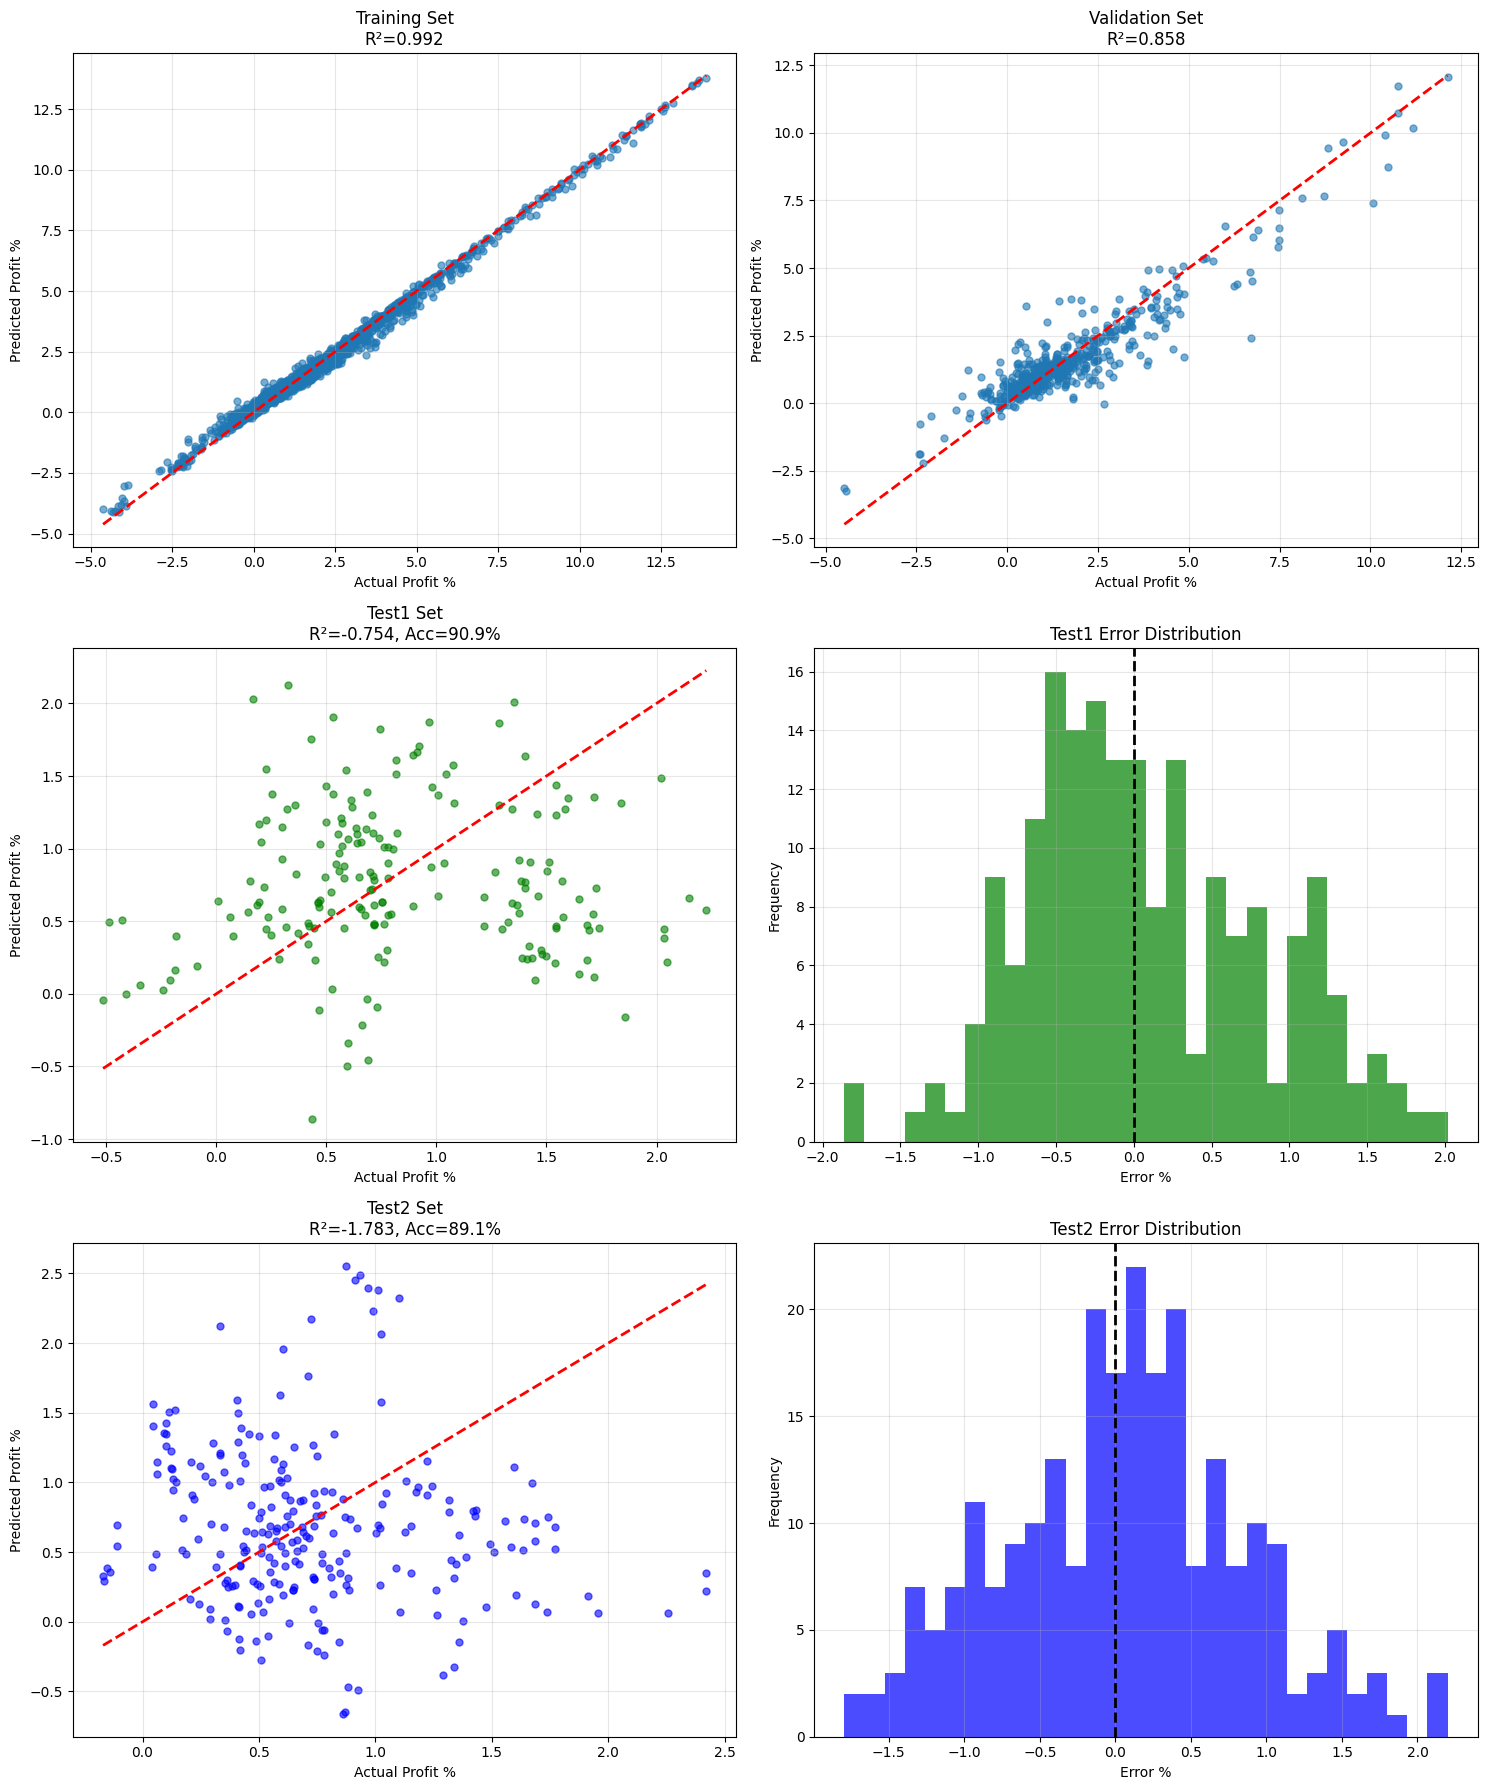

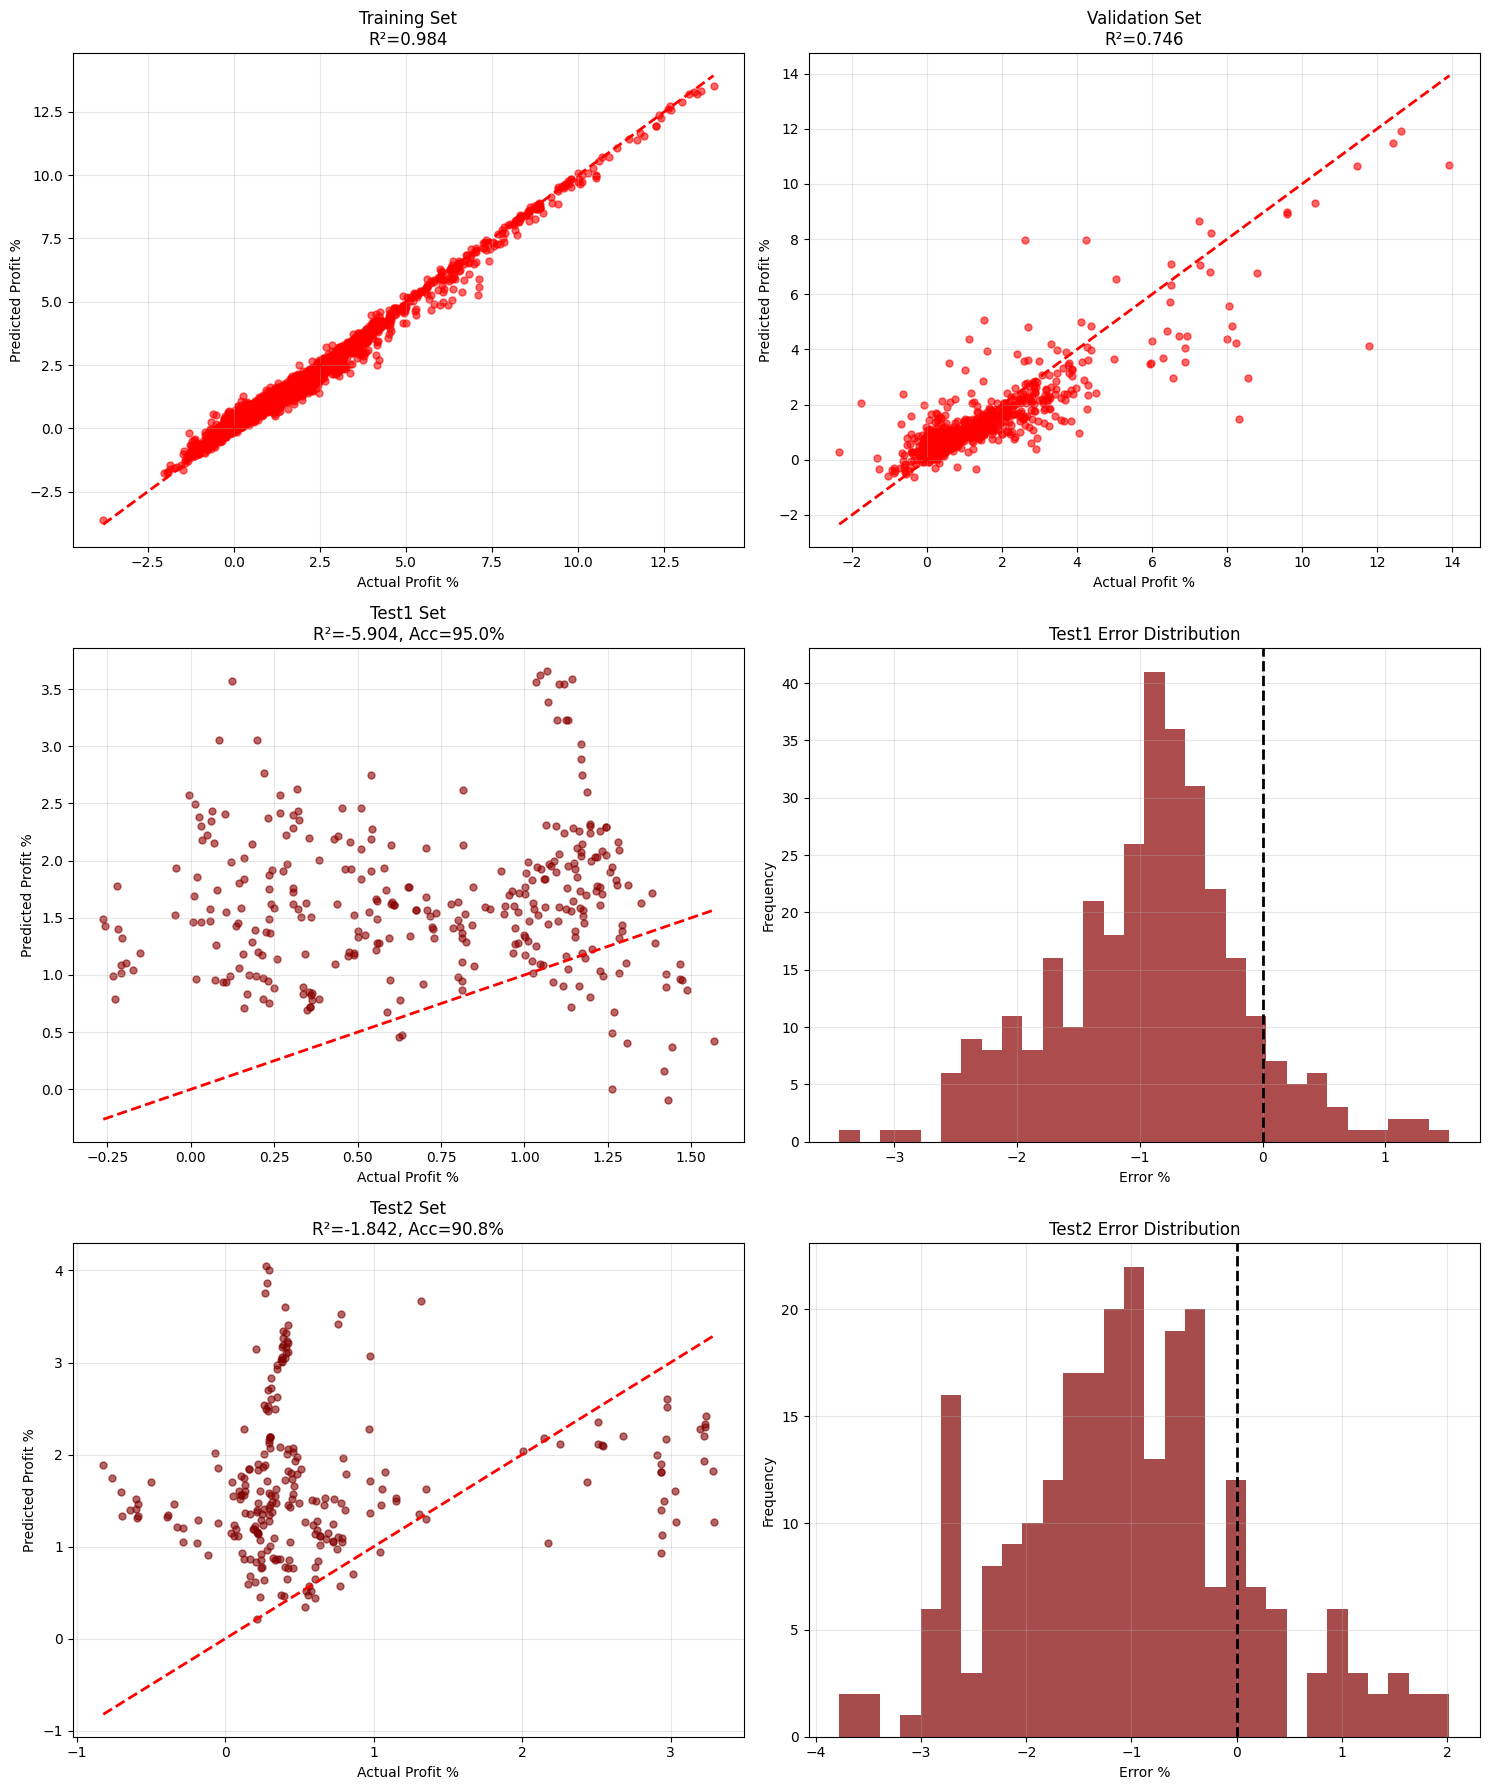

In [45]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings

# Configuration
TRAINING_DATA_PATH = "./output/enhanced_bs_features/SPY_testing_dataset_20.1.1-12.31.csv"  # Path to your dataset
OUTPUT_DIR = "./output/model_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Split percentages
TRAIN_VAL_PERCENT = 0.90   # 90% for training and validation
TEST1_PERCENT = 0.05       # 5% for test1
TEST2_PERCENT = 0.05       # 5% for test2

# Calculate train and validation percentages from within the TRAIN_VAL_PERCENT
TRAIN_WITHIN_TRAINVAL = 0.85  # 85% of the train_val data for training
VAL_WITHIN_TRAINVAL = 0.15    # 15% of the train_val data for validation

print("=" * 80)
print("Dual Test Phase Model Training - Chronological Test1/Test2 + Random Train/Val")
print("=" * 80)

# Load dataset
print("\n[1/9] Loading dataset...")
df = pd.read_csv(TRAINING_DATA_PATH)
print(f"Data shape: {df.shape}")

# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Time-based splitting using percentages
print("\n[2/9] Performing hybrid split (chronological test phases, random train/val)...")

# Sort by timestamp to ensure chronological order
df = df.sort_values('timestamp')

# ========== MODIFIED SPLIT STRATEGY ==========
# First, separate out test1 and test2 sets (last 10% of data chronologically split in half)
total_rows = len(df)
train_val_end_idx = int(total_rows * TRAIN_VAL_PERCENT)
test1_end_idx = int(total_rows * (TRAIN_VAL_PERCENT + TEST1_PERCENT))

# Split into train_val (first 90%), test1 (next 5%), and test2 (last 5%)
train_val_df = df.iloc[:train_val_end_idx].copy()
test1_df = df.iloc[train_val_end_idx:test1_end_idx].copy()
test2_df = df.iloc[test1_end_idx:].copy()

# Now randomly split train_val data into train and validation
train_df, validation_df = train_test_split(
    train_val_df, 
    test_size=VAL_WITHIN_TRAINVAL,  # 15% of train_val data
    random_state=42
)
# ========== END MODIFICATIONS ==========

# Report on the split
print(f"Total data points: {total_rows}")
print(f"Training data (random {TRAIN_WITHIN_TRAINVAL*100:.1f}% from first {TRAIN_VAL_PERCENT*100:.1f}%): {len(train_df)} samples")
print(f"Validation data (random {VAL_WITHIN_TRAINVAL*100:.1f}% from first {TRAIN_VAL_PERCENT*100:.1f}%): {len(validation_df)} samples")
print(f"Test1 data (chronological {TEST1_PERCENT*100:.1f}%): {len(test1_df)} samples")
print(f"Test2 data (chronological last {TEST2_PERCENT*100:.1f}%): {len(test2_df)} samples")

# Display date ranges for each split
if len(train_df) > 0:
    print(f"Training date range: {train_df['timestamp'].min()} to {train_df['timestamp'].max()}")
if len(validation_df) > 0:
    print(f"Validation date range: {validation_df['timestamp'].min()} to {validation_df['timestamp'].max()}")
if len(test1_df) > 0:
    print(f"Test1 date range: {test1_df['timestamp'].min()} to {test1_df['timestamp'].max()}")
if len(test2_df) > 0:
    print(f"Test2 date range: {test2_df['timestamp'].min()} to {test2_df['timestamp'].max()}")

# Identify feature columns
print("\n[3/9] Identifying feature columns...")

# Exclude metadata and target columns
exclude_patterns = ['timestamp', 'bsp_type', 'direction', 'profit_target', 
                   'has_profit', 'return_', 'label_', 'target_return_', 
                   'snapshot_', 'klu_idx', 'exit_']

# Filter to feature columns only
feature_cols = [col for col in df.columns 
                if not any(pat in col for pat in exclude_patterns)]

# Remove encoded columns if original exists
if 'direction' in feature_cols and 'direction_encoded' in feature_cols:
    feature_cols.remove('direction')
if 'bsp_type' in feature_cols and 'bsp_type_encoded' in feature_cols:
    feature_cols.remove('bsp_type')

feature_cols = sorted(feature_cols)
print(f"Features identified: {len(feature_cols)}")

# Split data by direction
print("\n[4/9] Splitting data by direction...")

# Filter to valid samples (those with profit targets)
train_valid = train_df[train_df['has_profit_target'] == 1].copy()
train_buy = train_valid[train_valid['direction'] == 'buy'].copy()
train_sell = train_valid[train_valid['direction'] == 'sell'].copy()

val_valid = validation_df[validation_df['has_profit_target'] == 1].copy()
val_buy = val_valid[val_valid['direction'] == 'buy'].copy()
val_sell = val_valid[val_valid['direction'] == 'sell'].copy()

test1_valid = test1_df[test1_df['has_profit_target'] == 1].copy()
test1_buy = test1_valid[test1_valid['direction'] == 'buy'].copy()
test1_sell = test1_valid[test1_valid['direction'] == 'sell'].copy()

test2_valid = test2_df[test2_df['has_profit_target'] == 1].copy()
test2_buy = test2_valid[test2_valid['direction'] == 'buy'].copy()
test2_sell = test2_valid[test2_valid['direction'] == 'sell'].copy()

print("\nTraining data:")
print(f"  Total valid signals: {len(train_valid):>6} samples")
if len(train_valid) > 0:
    print(f"  Buy signals:  {len(train_buy):>6} samples ({len(train_buy)/len(train_valid)*100:>5.1f}% of valid)")
    print(f"  Sell signals: {len(train_sell):>6} samples ({len(train_sell)/len(train_valid)*100:>5.1f}% of valid)")
else:
    print("  No valid signals found in training data.")

print("\nValidation data:")
print(f"  Total valid signals: {len(val_valid):>6} samples")
if len(val_valid) > 0:
    print(f"  Buy signals:  {len(val_buy):>6} samples ({len(val_buy)/len(val_valid)*100:>5.1f}% of valid)")
    print(f"  Sell signals: {len(val_sell):>6} samples ({len(val_sell)/len(val_valid)*100:>5.1f}% of valid)")
else:
    print("  No valid signals found in validation data.")

print("\nTest1 data:")
print(f"  Total valid signals: {len(test1_valid):>6} samples")
if len(test1_valid) > 0:
    print(f"  Buy signals:  {len(test1_buy):>6} samples ({len(test1_buy)/len(test1_valid)*100:>5.1f}% of valid)")
    print(f"  Sell signals: {len(test1_sell):>6} samples ({len(test1_sell)/len(test1_valid)*100:>5.1f}% of valid)")
else:
    print("  No valid signals found in test1 data.")

print("\nTest2 data:")
print(f"  Total valid signals: {len(test2_valid):>6} samples")
if len(test2_valid) > 0:
    print(f"  Buy signals:  {len(test2_buy):>6} samples ({len(test2_buy)/len(test2_valid)*100:>5.1f}% of valid)")
    print(f"  Sell signals: {len(test2_sell):>6} samples ({len(test2_sell)/len(test2_valid)*100:>5.1f}% of valid)")
else:
    print("  No valid signals found in test2 data.")

# Check if we have enough data to proceed
if len(train_valid) == 0:
    raise ValueError("No valid training samples found. Cannot proceed.")

# Prepare data for model training
print("\n[5/9] Preparing data for model training...")

# Buy model data
X_train_buy = train_buy[feature_cols].fillna(0)
y_train_buy = train_buy['profit_target_pct']

X_val_buy = val_buy[feature_cols].fillna(0)
y_val_buy = val_buy['profit_target_pct']

X_test1_buy = test1_buy[feature_cols].fillna(0)
y_test1_buy = test1_buy['profit_target_pct']

X_test2_buy = test2_buy[feature_cols].fillna(0)
y_test2_buy = test2_buy['profit_target_pct']

# Sell model data
X_train_sell = train_sell[feature_cols].fillna(0)
y_train_sell = train_sell['profit_target_pct']

X_val_sell = val_sell[feature_cols].fillna(0)
y_val_sell = val_sell['profit_target_pct']

X_test1_sell = test1_sell[feature_cols].fillna(0)
y_test1_sell = test1_sell['profit_target_pct']

X_test2_sell = test2_sell[feature_cols].fillna(0)
y_test2_sell = test2_sell['profit_target_pct']

# Print dataset dimensions
print(f"Buy model datasets:")
print(f"  Training:   {X_train_buy.shape}")
print(f"  Validation: {X_val_buy.shape}")
print(f"  Test1:      {X_test1_buy.shape}")
print(f"  Test2:      {X_test2_buy.shape}")

print(f"Sell model datasets:")
print(f"  Training:   {X_train_sell.shape}")
print(f"  Validation: {X_val_sell.shape}")
print(f"  Test1:      {X_test1_sell.shape}")
print(f"  Test2:      {X_test2_sell.shape}")

# Model training - SIMPLIFIED FOR COMPATIBILITY
print("\n[6/9] Training models...")

# SIMPLIFIED model parameters
params = {
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 300,
    'random_state': 42
}

# Train buy model - SIMPLIFIED FOR COMPATIBILITY
print("\nTraining BUY model...")
buy_model_trained = False
if len(X_train_buy) > 0:
    model_buy = xgb.XGBRegressor(**params)
    
    # Simple fit call with no extra parameters
    model_buy.fit(X_train_buy, y_train_buy)
    
    buy_model_trained = True
    print("Buy model training complete")
else:
    print("Not enough data to train buy model")

# Train sell model - SIMPLIFIED FOR COMPATIBILITY
print("\nTraining SELL model...")
sell_model_trained = False
if len(X_train_sell) > 0:
    model_sell = xgb.XGBRegressor(**params)
    
    # Simple fit call with no extra parameters
    model_sell.fit(X_train_sell, y_train_sell)
    
    sell_model_trained = True
    print("Sell model training complete")
else:
    print("Not enough data to train sell model")

# Evaluate models
print("\n[7/9] Evaluating model performance...")

# Function to calculate metrics
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate accuracy (correct direction prediction)
    correct_direction = np.mean((y_true > 0) == (y_pred > 0)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': correct_direction
    }

# Buy model evaluation
buy_train_metrics = None
buy_val_metrics = None
buy_test1_metrics = None
buy_test2_metrics = None
y_test1_buy_pred = None
y_test2_buy_pred = None

if buy_model_trained:
    # Make predictions
    y_train_buy_pred = model_buy.predict(X_train_buy)
    y_val_buy_pred = model_buy.predict(X_val_buy)
    y_test1_buy_pred = model_buy.predict(X_test1_buy)
    y_test2_buy_pred = model_buy.predict(X_test2_buy)
    
    # Calculate metrics
    buy_train_metrics = calculate_metrics(y_train_buy, y_train_buy_pred)
    buy_val_metrics = calculate_metrics(y_val_buy, y_val_buy_pred)
    buy_test1_metrics = calculate_metrics(y_test1_buy, y_test1_buy_pred)
    buy_test2_metrics = calculate_metrics(y_test2_buy, y_test2_buy_pred)
    
    print("\nBUY MODEL METRICS:")
    print(f"  Training:   R² = {buy_train_metrics['R2']:.4f}, RMSE = {buy_train_metrics['RMSE']:.4f}%, Acc = {buy_train_metrics['Accuracy']:.2f}%")
    print(f"  Validation: R² = {buy_val_metrics['R2']:.4f}, RMSE = {buy_val_metrics['RMSE']:.4f}%, Acc = {buy_val_metrics['Accuracy']:.2f}%")
    print(f"  Test1:      R² = {buy_test1_metrics['R2']:.4f}, RMSE = {buy_test1_metrics['RMSE']:.4f}%, Acc = {buy_test1_metrics['Accuracy']:.2f}%")
    print(f"  Test2:      R² = {buy_test2_metrics['R2']:.4f}, RMSE = {buy_test2_metrics['RMSE']:.4f}%, Acc = {buy_test2_metrics['Accuracy']:.2f}%")
    
    # Feature importance
    importance_buy = model_buy.feature_importances_
    feature_importance_buy = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance_buy
    })
    feature_importance_buy = feature_importance_buy.sort_values('importance', ascending=False)

# Sell model evaluation
sell_train_metrics = None
sell_val_metrics = None
sell_test1_metrics = None
sell_test2_metrics = None
y_test1_sell_pred = None
y_test2_sell_pred = None

if sell_model_trained:
    # Make predictions
    y_train_sell_pred = model_sell.predict(X_train_sell)
    y_val_sell_pred = model_sell.predict(X_val_sell)
    y_test1_sell_pred = model_sell.predict(X_test1_sell)
    y_test2_sell_pred = model_sell.predict(X_test2_sell)
    
    # Calculate metrics
    sell_train_metrics = calculate_metrics(y_train_sell, y_train_sell_pred)
    sell_val_metrics = calculate_metrics(y_val_sell, y_val_sell_pred)
    sell_test1_metrics = calculate_metrics(y_test1_sell, y_test1_sell_pred)
    sell_test2_metrics = calculate_metrics(y_test2_sell, y_test2_sell_pred)
    
    print("\nSELL MODEL METRICS:")
    print(f"  Training:   R² = {sell_train_metrics['R2']:.4f}, RMSE = {sell_train_metrics['RMSE']:.4f}%, Acc = {sell_train_metrics['Accuracy']:.2f}%")
    print(f"  Validation: R² = {sell_val_metrics['R2']:.4f}, RMSE = {sell_val_metrics['RMSE']:.4f}%, Acc = {sell_val_metrics['Accuracy']:.2f}%")
    print(f"  Test1:      R² = {sell_test1_metrics['R2']:.4f}, RMSE = {sell_test1_metrics['RMSE']:.4f}%, Acc = {sell_test1_metrics['Accuracy']:.2f}%")
    print(f"  Test2:      R² = {sell_test2_metrics['R2']:.4f}, RMSE = {sell_test2_metrics['RMSE']:.4f}%, Acc = {sell_test2_metrics['Accuracy']:.2f}%")
    
    # Feature importance
    importance_sell = model_sell.feature_importances_
    feature_importance_sell = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance_sell
    })
    feature_importance_sell = feature_importance_sell.sort_values('importance', ascending=False)

# Visualizations
print("\n[8/9] Creating visualizations...")

# Buy model plots
if buy_model_trained:
    # Create a 3x2 grid for the buy model (adding test2)
    plt.figure(figsize=(15, 18))
    gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1])
    
    # Training scatter plot
    ax1 = plt.subplot(gs[0, 0])
    ax1.scatter(y_train_buy, y_train_buy_pred, alpha=0.6, s=25)
    ax1.plot([y_train_buy.min(), y_train_buy.max()], 
             [y_train_buy.min(), y_train_buy.max()], 'r--', lw=2)
    ax1.set_title(f'Training Set\nR²={buy_train_metrics["R2"]:.3f}')
    ax1.set_xlabel('Actual Profit %')
    ax1.set_ylabel('Predicted Profit %')
    ax1.grid(True, alpha=0.3)
    
    # Validation scatter plot
    ax2 = plt.subplot(gs[0, 1])
    ax2.scatter(y_val_buy, y_val_buy_pred, alpha=0.6, s=25)
    ax2.plot([y_val_buy.min(), y_val_buy.max()], 
             [y_val_buy.min(), y_val_buy.max()], 'r--', lw=2)
    ax2.set_title(f'Validation Set\nR²={buy_val_metrics["R2"]:.3f}')
    ax2.set_xlabel('Actual Profit %')
    ax2.set_ylabel('Predicted Profit %')
    ax2.grid(True, alpha=0.3)
    
    # Test1 scatter plot
    ax3 = plt.subplot(gs[1, 0])
    ax3.scatter(y_test1_buy, y_test1_buy_pred, alpha=0.6, s=25, color='green')
    ax3.plot([y_test1_buy.min(), y_test1_buy.max()], 
             [y_test1_buy.min(), y_test1_buy.max()], 'r--', lw=2)
    ax3.set_title(f'Test1 Set\nR²={buy_test1_metrics["R2"]:.3f}, Acc={buy_test1_metrics["Accuracy"]:.1f}%')
    ax3.set_xlabel('Actual Profit %')
    ax3.set_ylabel('Predicted Profit %')
    ax3.grid(True, alpha=0.3)
    
    # Test1 Residuals
    ax4 = plt.subplot(gs[1, 1])
    test1_residuals = y_test1_buy - y_test1_buy_pred
    ax4.hist(test1_residuals, bins=30, alpha=0.7, color='green')
    ax4.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax4.set_title('Test1 Error Distribution')
    ax4.set_xlabel('Error %')
    ax4.set_ylabel('Frequency')
    ax4.grid(True, alpha=0.3)
    
    # Test2 scatter plot
    ax5 = plt.subplot(gs[2, 0])
    ax5.scatter(y_test2_buy, y_test2_buy_pred, alpha=0.6, s=25, color='blue')
    ax5.plot([y_test2_buy.min(), y_test2_buy.max()], 
             [y_test2_buy.min(), y_test2_buy.max()], 'r--', lw=2)
    ax5.set_title(f'Test2 Set\nR²={buy_test2_metrics["R2"]:.3f}, Acc={buy_test2_metrics["Accuracy"]:.1f}%')
    ax5.set_xlabel('Actual Profit %')
    ax5.set_ylabel('Predicted Profit %')
    ax5.grid(True, alpha=0.3)
    
    # Test2 Residuals
    ax6 = plt.subplot(gs[2, 1])
    test2_residuals = y_test2_buy - y_test2_buy_pred
    ax6.hist(test2_residuals, bins=30, alpha=0.7, color='blue')
    ax6.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax6.set_title('Test2 Error Distribution')
    ax6.set_xlabel('Error %')
    ax6.set_ylabel('Frequency')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/buy_model_dual_test.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {OUTPUT_DIR}/buy_model_dual_test.png")

# Sell model plots
if sell_model_trained:
    # Create a 3x2 grid for the sell model (adding test2)
    plt.figure(figsize=(15, 18))
    gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1])
    
    # Training scatter plot
    ax1 = plt.subplot(gs[0, 0])
    ax1.scatter(y_train_sell, y_train_sell_pred, alpha=0.6, s=25, color='red')
    ax1.plot([y_train_sell.min(), y_train_sell.max()], 
             [y_train_sell.min(), y_train_sell.max()], 'r--', lw=2)
    ax1.set_title(f'Training Set\nR²={sell_train_metrics["R2"]:.3f}')
    ax1.set_xlabel('Actual Profit %')
    ax1.set_ylabel('Predicted Profit %')
    ax1.grid(True, alpha=0.3)
    
    # Validation scatter plot
    ax2 = plt.subplot(gs[0, 1])
    ax2.scatter(y_val_sell, y_val_sell_pred, alpha=0.6, s=25, color='red')
    ax2.plot([y_val_sell.min(), y_val_sell.max()], 
             [y_val_sell.min(), y_val_sell.max()], 'r--', lw=2)
    ax2.set_title(f'Validation Set\nR²={sell_val_metrics["R2"]:.3f}')
    ax2.set_xlabel('Actual Profit %')
    ax2.set_ylabel('Predicted Profit %')
    ax2.grid(True, alpha=0.3)
    
    # Test1 scatter plot
    ax3 = plt.subplot(gs[1, 0])
    ax3.scatter(y_test1_sell, y_test1_sell_pred, alpha=0.6, s=25, color='darkred')
    ax3.plot([y_test1_sell.min(), y_test1_sell.max()], 
             [y_test1_sell.min(), y_test1_sell.max()], 'r--', lw=2)
    ax3.set_title(f'Test1 Set\nR²={sell_test1_metrics["R2"]:.3f}, Acc={sell_test1_metrics["Accuracy"]:.1f}%')
    ax3.set_xlabel('Actual Profit %')
    ax3.set_ylabel('Predicted Profit %')
    ax3.grid(True, alpha=0.3)
    
    # Test1 Residuals
    ax4 = plt.subplot(gs[1, 1])
    test1_residuals = y_test1_sell - y_test1_sell_pred
    ax4.hist(test1_residuals, bins=30, alpha=0.7, color='darkred')
    ax4.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax4.set_title('Test1 Error Distribution')
    ax4.set_xlabel('Error %')
    ax4.set_ylabel('Frequency')
    ax4.grid(True, alpha=0.3)
    
    # Test2 scatter plot
    ax5 = plt.subplot(gs[2, 0])
    ax5.scatter(y_test2_sell, y_test2_sell_pred, alpha=0.6, s=25, color='maroon')
    ax5.plot([y_test2_sell.min(), y_test2_sell.max()], 
             [y_test2_sell.min(), y_test2_sell.max()], 'r--', lw=2)
    ax5.set_title(f'Test2 Set\nR²={sell_test2_metrics["R2"]:.3f}, Acc={sell_test2_metrics["Accuracy"]:.1f}%')
    ax5.set_xlabel('Actual Profit %')
    ax5.set_ylabel('Predicted Profit %')
    ax5.grid(True, alpha=0.3)
    
    # Test2 Residuals
    ax6 = plt.subplot(gs[2, 1])
    test2_residuals = y_test2_sell - y_test2_sell_pred
    ax6.hist(test2_residuals, bins=30, alpha=0.7, color='maroon')
    ax6.axvline(x=0, color='black', linestyle='--', linewidth=2)
    ax6.set_title('Test2 Error Distribution')
    ax6.set_xlabel('Error %')
    ax6.set_ylabel('Frequency')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/sell_model_dual_test.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {OUTPUT_DIR}/sell_model_dual_test.png")

# Save models and results
print("\n[9/9] Saving models and results...")

# Save buy model and results
if buy_model_trained:
    model_buy.save_model(f"{OUTPUT_DIR}/xgboost_buy_model_dual_test.json")
    print(f"Saved: {OUTPUT_DIR}/xgboost_buy_model_dual_test.json")
    
    # Save feature importance
    feature_importance_buy.to_csv(f"{OUTPUT_DIR}/buy_model_feature_importance_dual_test.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/buy_model_feature_importance_dual_test.csv")
    
    # Save Test1 results
    test1_buy_results = test1_buy.copy()
    test1_buy_results['predicted_profit_pct'] = y_test1_buy_pred
    test1_buy_results['prediction_error'] = y_test1_buy - y_test1_buy_pred
    test1_buy_results['correct_direction'] = (
        (test1_buy_results['profit_target_pct'] > 0) == 
        (test1_buy_results['predicted_profit_pct'] > 0)
    ).astype(int)
    test1_buy_results.to_csv(f"{OUTPUT_DIR}/buy_model_predictions_test1.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/buy_model_predictions_test1.csv")
    
    # Save Test2 results
    test2_buy_results = test2_buy.copy()
    test2_buy_results['predicted_profit_pct'] = y_test2_buy_pred
    test2_buy_results['prediction_error'] = y_test2_buy - y_test2_buy_pred
    test2_buy_results['correct_direction'] = (
        (test2_buy_results['profit_target_pct'] > 0) == 
        (test2_buy_results['predicted_profit_pct'] > 0)
    ).astype(int)
    test2_buy_results.to_csv(f"{OUTPUT_DIR}/buy_model_predictions_test2.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/buy_model_predictions_test2.csv")

# Save sell model and results
if sell_model_trained:
    model_sell.save_model(f"{OUTPUT_DIR}/xgboost_sell_model_dual_test.json")
    print(f"Saved: {OUTPUT_DIR}/xgboost_sell_model_dual_test.json")
    
    # Save feature importance
    feature_importance_sell.to_csv(f"{OUTPUT_DIR}/sell_model_feature_importance_dual_test.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/sell_model_feature_importance_dual_test.csv")
    
    # Save Test1 results
    test1_sell_results = test1_sell.copy()
    test1_sell_results['predicted_profit_pct'] = y_test1_sell_pred
    test1_sell_results['prediction_error'] = y_test1_sell - y_test1_sell_pred
    test1_sell_results['correct_direction'] = (
        (test1_sell_results['profit_target_pct'] > 0) == 
        (test1_sell_results['predicted_profit_pct'] > 0)
    ).astype(int)
    test1_sell_results.to_csv(f"{OUTPUT_DIR}/sell_model_predictions_test1.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/sell_model_predictions_test1.csv")
    
    # Save Test2 results
    test2_sell_results = test2_sell.copy()
    test2_sell_results['predicted_profit_pct'] = y_test2_sell_pred
    test2_sell_results['prediction_error'] = y_test2_sell - y_test2_sell_pred
    test2_sell_results['correct_direction'] = (
        (test2_sell_results['profit_target_pct'] > 0) == 
        (test2_sell_results['predicted_profit_pct'] > 0)
    ).astype(int)
    test2_sell_results.to_csv(f"{OUTPUT_DIR}/sell_model_predictions_test2.csv", index=False)
    print(f"Saved: {OUTPUT_DIR}/sell_model_predictions_test2.csv")

# Summary report
with open(f"{OUTPUT_DIR}/dual_test_models_summary.txt", 'w') as f:
    f.write("Dual-Test Buy/Sell Models - Summary Report\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("DATA SPLIT STRATEGY:\n")
    f.write(f"  First {TRAIN_VAL_PERCENT*100:.1f}% randomly split into {TRAIN_WITHIN_TRAINVAL*100:.1f}% train and {VAL_WITHIN_TRAINVAL*100:.1f}% validation\n")
    f.write(f"  Next {TEST1_PERCENT*100:.1f}% chronologically reserved for Test1\n")
    f.write(f"  Last {TEST2_PERCENT*100:.1f}% chronologically reserved for Test2\n\n")
    
    f.write("DATA SPLIT:\n")
    f.write(f"  Training set:\n")
    f.write(f"    Total valid signals: {len(train_valid):>6} samples\n")
    if len(train_valid) > 0:
        f.write(f"    Buy signals:  {len(train_buy):>6} samples ({len(train_buy)/len(train_valid)*100:>5.1f}%)\n")
        f.write(f"    Sell signals: {len(train_sell):>6} samples ({len(train_sell)/len(train_valid)*100:>5.1f}%)\n")
    
    f.write(f"  Validation set:\n")
    f.write(f"    Total valid signals: {len(val_valid):>6} samples\n")
    if len(val_valid) > 0:
        f.write(f"    Buy signals:  {len(val_buy):>6} samples ({len(val_buy)/len(val_valid)*100:>5.1f}%)\n")
        f.write(f"    Sell signals: {len(val_sell):>6} samples ({len(val_sell)/len(val_valid)*100:>5.1f}%)\n")
    
    f.write(f"  Test1 set:\n")
    f.write(f"    Total valid signals: {len(test1_valid):>6} samples\n")
    if len(test1_valid) > 0:
        f.write(f"    Buy signals:  {len(test1_buy):>6} samples ({len(test1_buy)/len(test1_valid)*100:>5.1f}%)\n")
        f.write(f"    Sell signals: {len(test1_sell):>6} samples ({len(test1_sell)/len(test1_valid)*100:>5.1f}%)\n")
    
    f.write(f"  Test2 set:\n")
    f.write(f"    Total valid signals: {len(test2_valid):>6} samples\n")
    if len(test2_valid) > 0:
        f.write(f"    Buy signals:  {len(test2_buy):>6} samples ({len(test2_buy)/len(test2_valid)*100:>5.1f}%)\n")
        f.write(f"    Sell signals: {len(test2_sell):>6} samples ({len(test2_sell)/len(test2_valid)*100:>5.1f}%)\n\n")
    
    if buy_model_trained:
        f.write("BUY MODEL PERFORMANCE:\n")
        f.write(f"  Training:\n")
        f.write(f"    RMSE: {buy_train_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {buy_train_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {buy_train_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {buy_train_metrics['Accuracy']:.2f}%\n")
        f.write(f"  Validation:\n")
        f.write(f"    RMSE: {buy_val_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {buy_val_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {buy_val_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {buy_val_metrics['Accuracy']:.2f}%\n")
        f.write(f"  Test1:\n")
        f.write(f"    RMSE: {buy_test1_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {buy_test1_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {buy_test1_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {buy_test1_metrics['Accuracy']:.2f}%\n")
        f.write(f"  Test2:\n")
        f.write(f"    RMSE: {buy_test2_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {buy_test2_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {buy_test2_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {buy_test2_metrics['Accuracy']:.2f}%\n\n")
    
    if sell_model_trained:
        f.write("SELL MODEL PERFORMANCE:\n")
        f.write(f"  Training:\n")
        f.write(f"    RMSE: {sell_train_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {sell_train_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {sell_train_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {sell_train_metrics['Accuracy']:.2f}%\n")
        f.write(f"  Validation:\n")
        f.write(f"    RMSE: {sell_val_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {sell_val_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {sell_val_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {sell_val_metrics['Accuracy']:.2f}%\n")
        f.write(f"  Test1:\n")
        f.write(f"    RMSE: {sell_test1_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {sell_test1_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {sell_test1_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {sell_test1_metrics['Accuracy']:.2f}%\n")
        f.write(f"  Test2:\n")
        f.write(f"    RMSE: {sell_test2_metrics['RMSE']:.4f}%\n")
        f.write(f"    MAE:  {sell_test2_metrics['MAE']:.4f}%\n")
        f.write(f"    R²:   {sell_test2_metrics['R2']:.4f}\n")
        f.write(f"    Acc:  {sell_test2_metrics['Accuracy']:.2f}%\n\n")
    
    if buy_model_trained:
        f.write("TOP 10 BUY MODEL FEATURES:\n")
        for i, row in feature_importance_buy.head(10).iterrows():
            f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")
    
    if sell_model_trained:
        f.write("\nTOP 10 SELL MODEL FEATURES:\n")
        for i, row in feature_importance_sell.head(10).iterrows():
            f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")

print(f"Saved: {OUTPUT_DIR}/dual_test_models_summary.txt")

# Final summary
print("\n" + "=" * 80)
print("DUAL-TEST MODEL TRAINING COMPLETE")
print("=" * 80)

if buy_model_trained:
    print(f"\n📊 BUY MODEL RESULTS:")
    print(f"  Training R²:             {buy_train_metrics['R2']:>7.4f}")
    print(f"  Validation R²:           {buy_val_metrics['R2']:>7.4f}")
    print(f"  Test1 R²:                {buy_test1_metrics['R2']:>7.4f}")
    print(f"  Test2 R²:                {buy_test2_metrics['R2']:>7.4f}")
    print(f"  Test1 Direction Accuracy: {buy_test1_metrics['Accuracy']:>7.2f}%")
    print(f"  Test2 Direction Accuracy: {buy_test2_metrics['Accuracy']:>7.2f}%")

if sell_model_trained:
    print(f"\n📊 SELL MODEL RESULTS:")
    print(f"  Training R²:             {sell_train_metrics['R2']:>7.4f}")
    print(f"  Validation R²:           {sell_val_metrics['R2']:>7.4f}")
    print(f"  Test1 R²:                {sell_test1_metrics['R2']:>7.4f}")
    print(f"  Test2 R²:                {sell_test2_metrics['R2']:>7.4f}")
    print(f"  Test1 Direction Accuracy: {sell_test1_metrics['Accuracy']:>7.2f}%")
    print(f"  Test2 Direction Accuracy: {sell_test2_metrics['Accuracy']:>7.2f}%")

print("\nAdvantages of dual-test split validation:")
print("1. More robust evaluation - testing on two separate time periods")
print("2. Better assessment of model stability - comparing performance between test1 and test2")
print("3. Stronger validation of time generalization - sequential test phases reveal drift")
print("4. Enhanced detection of overfitting - consistency between test1/test2 suggests generalization")

print(f"\n💾 All results saved to: {OUTPUT_DIR}/")

print("\nDual-test split summary:")
print(f"- First {TRAIN_VAL_PERCENT*100:.1f}% randomly split into {TRAIN_WITHIN_TRAINVAL*100:.1f}% train and {VAL_WITHIN_TRAINVAL*100:.1f}% validation")
print(f"- Next {TEST1_PERCENT*100:.1f}% chronologically reserved for Test1")
print(f"- Last {TEST2_PERCENT*100:.1f}% chronologically reserved for Test2")

Portfolio Backtesting: Hybrid-Split Model vs Buy & Hold

[1/5] Loading model predictions...
Loaded 247 buy signals and 250 sell signals
Test period: 2020-12-14 10:30:00 to 2020-12-31 14:05:00

[2/5] Preparing price series for comparison...
Unique price points in test period: 466

[3/5] Running backtest with hybrid-split models...

[4/5] Calculating performance metrics...

--------------------------------------------------------------------------------
HYBRID-SPLIT ML STRATEGY
--------------------------------------------------------------------------------
Strategy: Use hybrid-split buy_model for entries (>0.5%), sell_model for exits (>0.5%)
Position Size: 100% per trade
Final Portfolio Value: $10,377.39
Total Return: 3.77%
Max Drawdown: 2.10%
Total Trades: 37 (Completed: 37)
Winning Trades: 25/37 (67.6%)
Skipped Buy Signals: 58 (buy model predicted < 0.5%)
Skipped Sell Signals: 0 (sell model predicted < 0.5%)
Average Trade Return: 0.10%
Median Trade Return: 0.08%
Best Trade: 1.00%
Wors

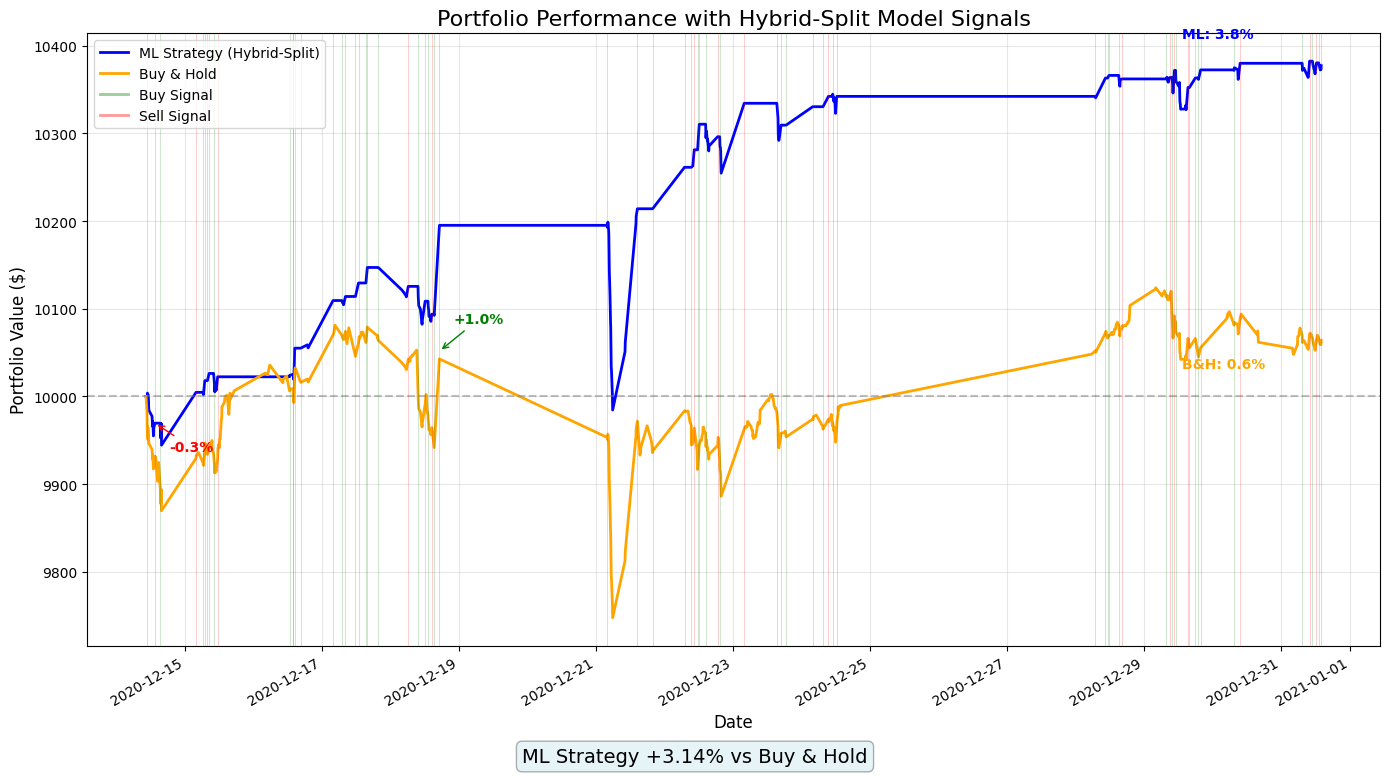

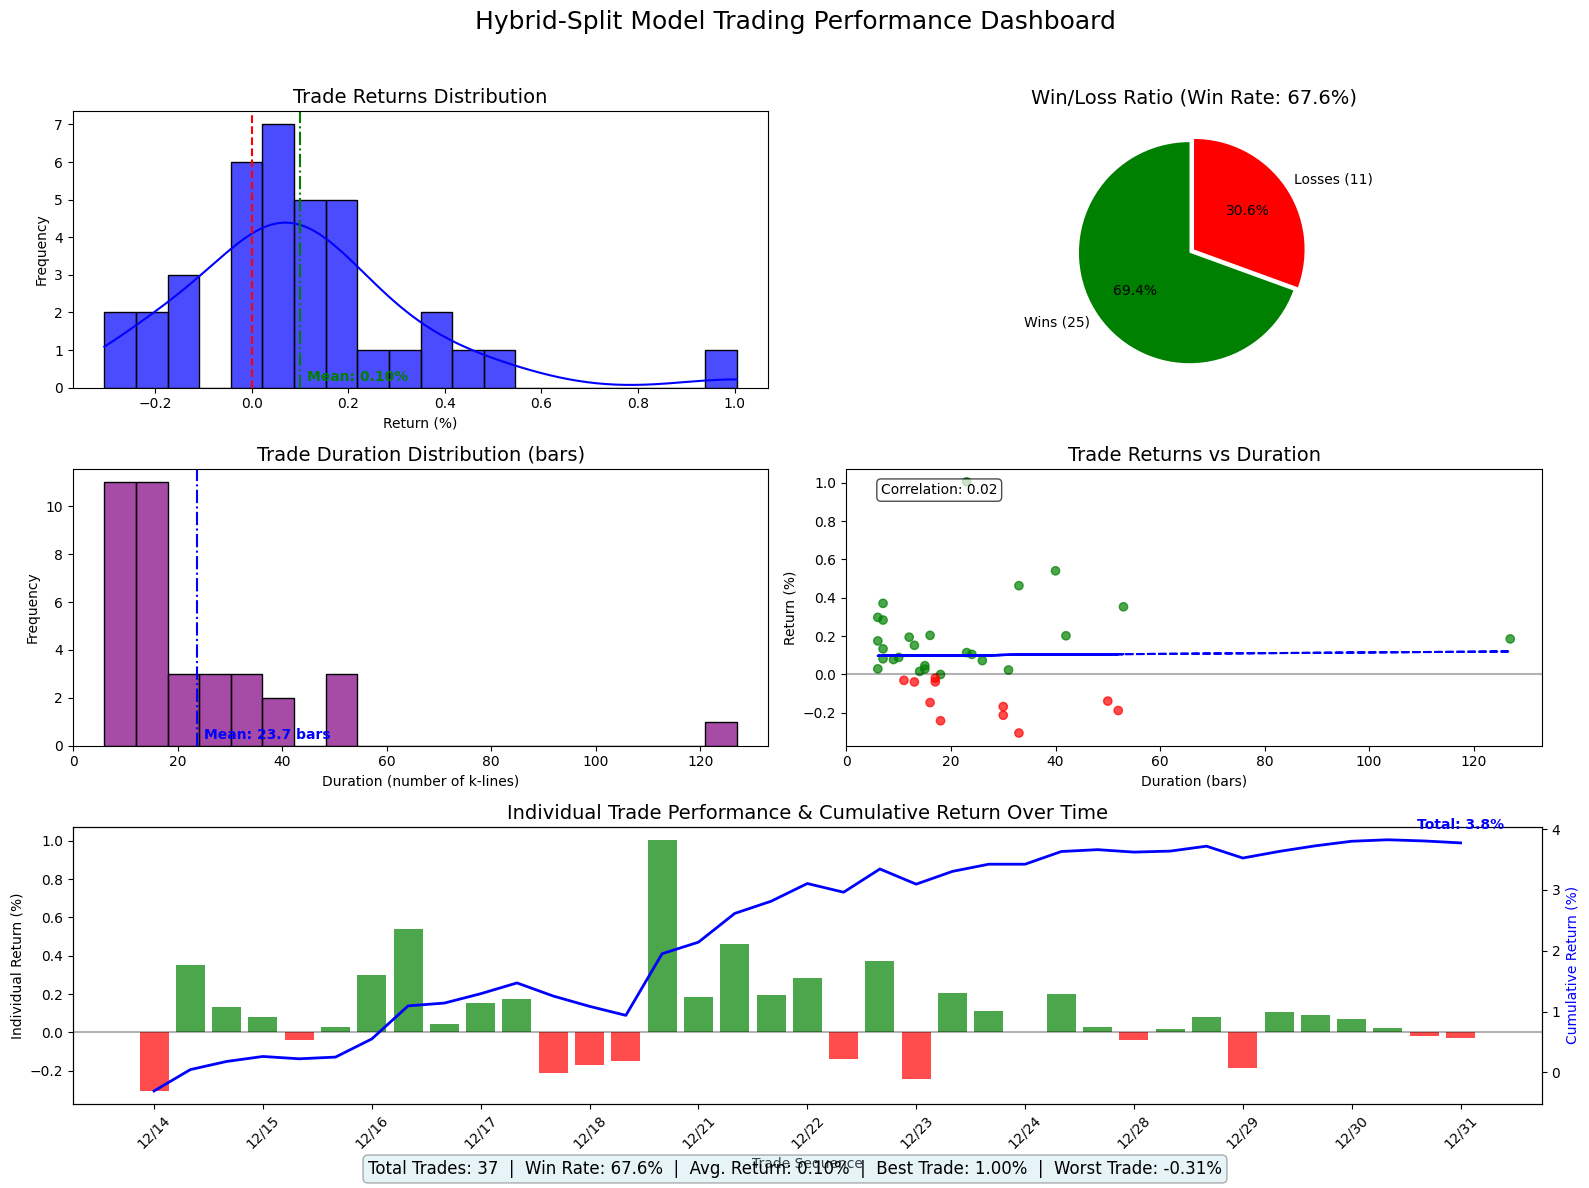

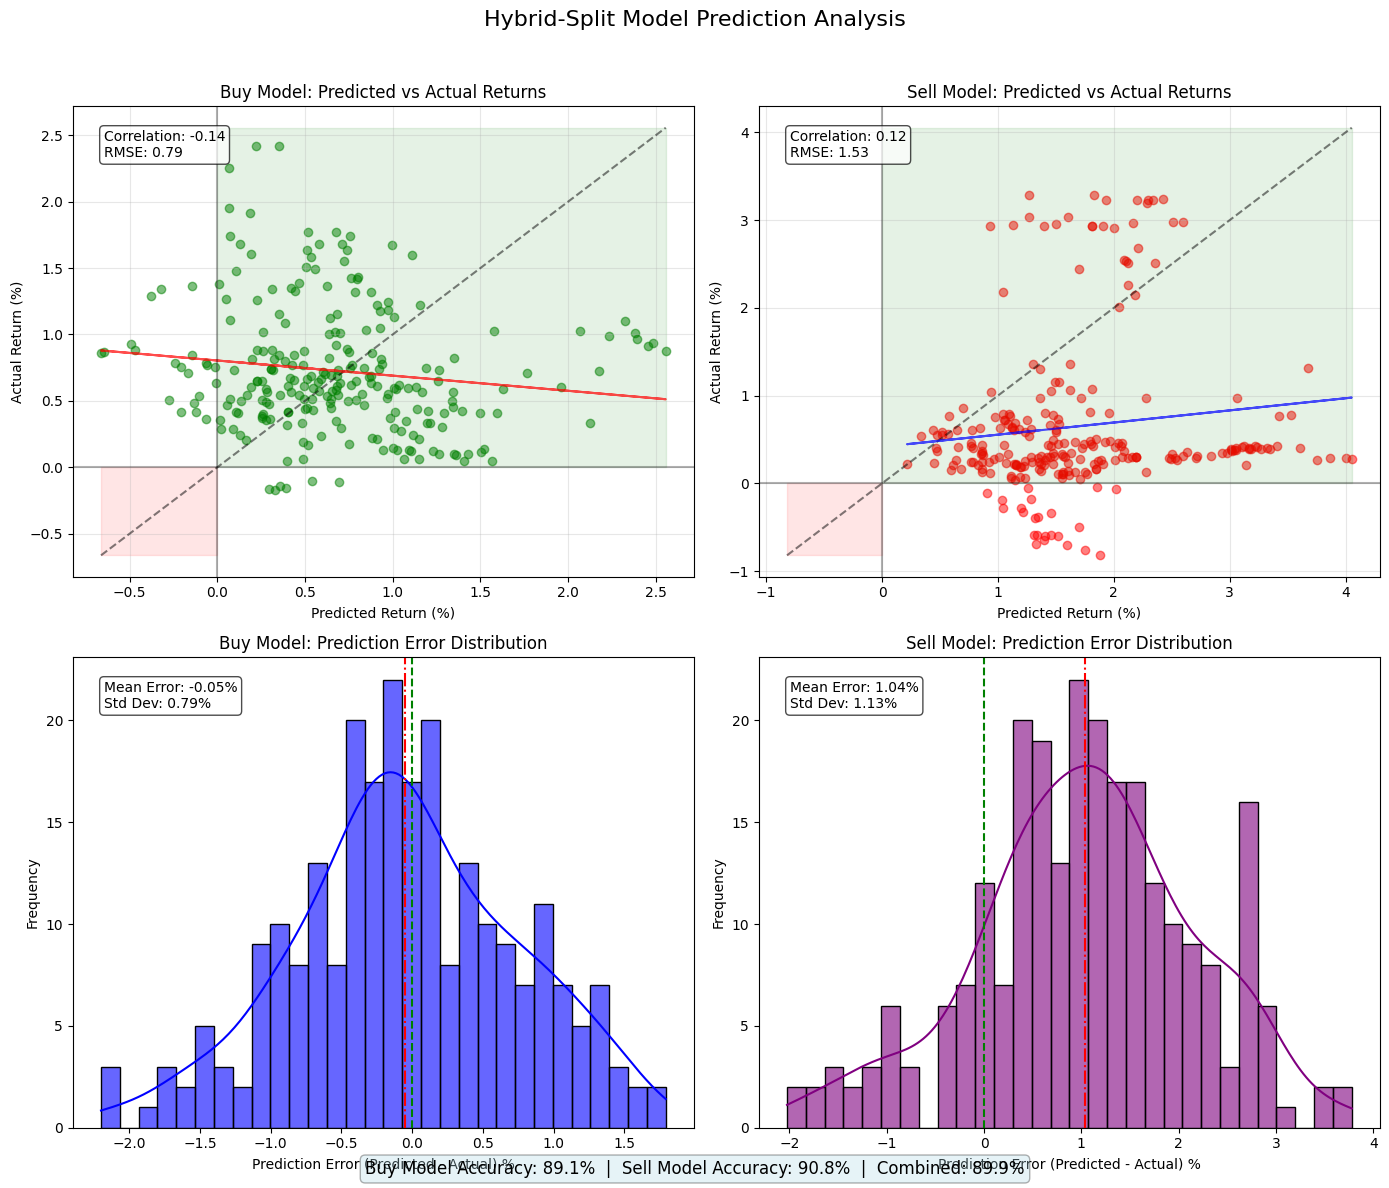

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import datetime

# Configuration
OUTPUT_DIR = "./output/model_results"
BACKTEST_OUTPUT_DIR = "./output/backtest_results"
Path(BACKTEST_OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(f"{BACKTEST_OUTPUT_DIR}/hybrid_model_charts").mkdir(parents=True, exist_ok=True)

# Paths to model prediction files 
#BUY_PREDICTIONS_PATH = f"{OUTPUT_DIR}/buy_model_predictions_hybrid_split.csv"
#SELL_PREDICTIONS_PATH = f"{OUTPUT_DIR}/sell_model_predictions_hybrid_split.csv"
BUY_PREDICTIONS_PATH = f"{OUTPUT_DIR}/buy_model_predictions_test2.csv"
SELL_PREDICTIONS_PATH = f"{OUTPUT_DIR}/sell_model_predictions_test2.csv"

# Strategy parameters
PROFIT_THRESHOLD_BUY = 0.5   # Buy threshold
PROFIT_THRESHOLD_SELL = 0.5  # Sell threshold (can be different!)
POSITION_SIZE = 1          # Use 100% of capital per trade
INITIAL_CAPITAL = 10000

print("=" * 80)
print("Portfolio Backtesting: Hybrid-Split Model vs Buy & Hold")
print("=" * 80)

# Load predictions from hybrid-split models
print("\n[1/5] Loading model predictions...")
try:
    df_buy = pd.read_csv(BUY_PREDICTIONS_PATH)
    df_sell = pd.read_csv(SELL_PREDICTIONS_PATH)
    print(f"Loaded {len(df_buy)} buy signals and {len(df_sell)} sell signals")
    
    # Check if data is available
    if len(df_buy) == 0 and len(df_sell) == 0:
        raise ValueError("No prediction data found in either buy or sell files")
except FileNotFoundError:
    print("Prediction files not found. Make sure to run the hybrid-split model training script first.")
    raise

# Combine buy and sell predictions for convenience, adding a 'direction' column
df_buy['direction'] = 'buy'
df_sell['direction'] = 'sell'
df_signals = pd.concat([df_buy, df_sell], ignore_index=True)

# Convert timestamp to datetime for better sorting
if 'timestamp' in df_signals.columns:
    df_signals['timestamp'] = pd.to_datetime(df_signals['timestamp'])

# Sort signals chronologically by timestamp or klu_idx to ensure proper order
if 'timestamp' in df_signals.columns:
    df_signals = df_signals.sort_values('timestamp').reset_index(drop=True)
else:
    df_signals = df_signals.sort_values('klu_idx').reset_index(drop=True)

# Extract time range for the test period
if 'timestamp' in df_signals.columns:
    test_start = df_signals['timestamp'].min()
    test_end = df_signals['timestamp'].max()
    print(f"Test period: {test_start} to {test_end}")
else:
    test_start_idx = df_signals['klu_idx'].min()
    test_end_idx = df_signals['klu_idx'].max()
    print(f"Test period klu_idx range: {test_start_idx} to {test_end_idx}")

# Prepare for the full dataset for buy & hold comparison
print("\n[2/5] Preparing price series for comparison...")

# Create a combined price series from the test data
all_test_data = df_signals.copy()

# Use klu_idx or timestamp as index, depending on what's available
if 'timestamp' in all_test_data.columns:
    all_test_data = all_test_data.sort_values('timestamp').drop_duplicates('timestamp')
    print(f"Unique price points in test period: {len(all_test_data)}")
else:
    all_test_data = all_test_data.sort_values('klu_idx').drop_duplicates('klu_idx')
    print(f"Unique price points in test period: {len(all_test_data)}")

# Initialize portfolios
print("\n[3/5] Running backtest with hybrid-split models...")

# ML Strategy Portfolio
ml_capital = INITIAL_CAPITAL
ml_cash = INITIAL_CAPITAL
ml_shares = 0  # Number of shares held
ml_entry_price = 0
ml_trades = []
ml_returns = []
ml_skipped_sells = 0  # Track skipped sell signals
ml_skipped_buys = 0   # Track skipped buy signals

# Create a dictionary to map index to ML portfolio value
ml_portfolio_values = {}

# Buy & Hold Portfolio
# Use the first price point from our test data
bh_entry_price = all_test_data.iloc[0]['klu_close']
bh_shares = INITIAL_CAPITAL / bh_entry_price
bh_portfolio_values = []

# Calculate Buy & Hold for the entire test period
for idx, row in all_test_data.iterrows():
    bh_portfolio_value = bh_shares * row['klu_close']
    bh_portfolio_values.append(bh_portfolio_value)

# Process ML signals using separate model predictions
for idx, row in df_signals.iterrows():
    current_price = row['klu_close']
    predicted_profit = row['predicted_profit_pct']
    actual_profit = row['profit_target_pct']
    direction = row['direction']
    timestamp = row['timestamp'] if 'timestamp' in row else None
    klu_idx = row['klu_idx']
    
    # Select threshold based on direction
    threshold = PROFIT_THRESHOLD_BUY if direction == 'buy' else PROFIT_THRESHOLD_SELL
    
    # === ML Strategy Logic ===
    
    if direction == 'buy' and ml_shares == 0:
        # BUY signal: Enter position if buy model predicts profit > buy threshold
        if predicted_profit >= PROFIT_THRESHOLD_BUY:
            trade_capital = ml_cash * POSITION_SIZE
            ml_shares = trade_capital / current_price
            ml_entry_price = current_price
            ml_cash -= trade_capital
            
            ml_trades.append({
                'entry_idx': idx,
                'entry_klu_idx': klu_idx,
                'entry_timestamp': timestamp,
                'direction': 'buy',
                'entry_price': current_price,
                'predicted_profit': predicted_profit,
                'position_size': trade_capital,
                'shares': ml_shares,
                'model_used': 'buy_model'
            })
        else:
            ml_skipped_buys += 1
    
    elif direction == 'sell' and ml_shares > 0:
        # SELL signal: Exit position if sell model predicts profit > sell threshold
        if predicted_profit >= PROFIT_THRESHOLD_SELL:
            exit_value = ml_shares * current_price
            trade_profit = exit_value - (ml_shares * ml_entry_price)
            trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
            
            ml_cash += exit_value
            
            # Record trade result
            if ml_trades:
                ml_trades[-1].update({
                    'exit_idx': idx,
                    'exit_klu_idx': klu_idx,
                    'exit_timestamp': timestamp,
                    'exit_price': current_price,
                    'exit_predicted_profit': predicted_profit,
                    'actual_profit': actual_profit,
                    'trade_profit': trade_profit,
                    'trade_return_pct': trade_return_pct,
                    'model_used_exit': 'sell_model'
                })
                ml_returns.append(trade_return_pct)
            
            # Reset position
            ml_shares = 0
            ml_entry_price = 0
        else:
            # Skip this sell signal (sell model predicts insufficient profit)
            ml_skipped_sells += 1
    
    # Calculate current portfolio value
    position_value = ml_shares * current_price
    ml_portfolio_value = ml_cash + position_value
    
    # Store portfolio value
    if 'timestamp' in row:
        ml_portfolio_values[row['timestamp']] = ml_portfolio_value
    else:
        ml_portfolio_values[row['klu_idx']] = ml_portfolio_value

# Close any open position at the end
if ml_shares > 0:
    final_price = df_signals.iloc[-1]['klu_close']
    exit_value = ml_shares * final_price
    trade_profit = exit_value - (ml_shares * ml_entry_price)
    trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
    
    ml_cash += exit_value
    
    if ml_trades:
        ml_trades[-1].update({
            'exit_idx': len(df_signals) - 1,
            'exit_klu_idx': df_signals.iloc[-1]['klu_idx'] if 'klu_idx' in df_signals.iloc[-1] else None,
            'exit_timestamp': df_signals.iloc[-1]['timestamp'] if 'timestamp' in df_signals.iloc[-1] else None,
            'exit_price': final_price,
            'exit_predicted_profit': None,
            'actual_profit': None,
            'trade_profit': trade_profit,
            'trade_return_pct': trade_return_pct,
            'note': 'Closed at end of period'
        })
        ml_returns.append(trade_return_pct)
    
    if 'timestamp' in df_signals.iloc[-1]:
        ml_portfolio_values[df_signals.iloc[-1]['timestamp']] = ml_cash
    elif 'klu_idx' in df_signals.iloc[-1]:
        ml_portfolio_values[df_signals.iloc[-1]['klu_idx']] = ml_cash

# Map ML portfolio values to full timeline (forward-fill for dates without signals)
ml_portfolio_timeline = []
last_ml_value = INITIAL_CAPITAL

# Determine the index field (timestamp or klu_idx)
index_field = 'timestamp' if 'timestamp' in all_test_data.columns else 'klu_idx'

for idx, row in all_test_data.iterrows():
    index_value = row[index_field]
    if index_value in ml_portfolio_values:
        last_ml_value = ml_portfolio_values[index_value]
    ml_portfolio_timeline.append(last_ml_value)

# Add portfolio values to the dataframe
all_test_data['ml_portfolio_value'] = ml_portfolio_timeline
all_test_data['bh_portfolio_value'] = bh_portfolio_values

# Calculate portfolio metrics
print("\n[4/5] Calculating performance metrics...")

# Final values
ml_final_value = ml_portfolio_timeline[-1] if ml_portfolio_timeline else INITIAL_CAPITAL
bh_final_value = bh_portfolio_values[-1] if bh_portfolio_values else INITIAL_CAPITAL

# Returns
ml_total_return = ((ml_final_value / INITIAL_CAPITAL) - 1) * 100
bh_total_return = ((bh_final_value / INITIAL_CAPITAL) - 1) * 100

# Max Drawdown for ML Strategy
ml_peak = INITIAL_CAPITAL
ml_max_drawdown = 0
for value in ml_portfolio_timeline:
    ml_peak = max(ml_peak, value)
    drawdown = (ml_peak - value) / ml_peak * 100
    ml_max_drawdown = max(ml_max_drawdown, drawdown)

# Trade statistics
ml_completed_trades = sum(1 for trade in ml_trades if 'exit_price' in trade)
ml_winning_trades = sum(1 for trade in ml_trades if 'trade_return_pct' in trade and trade['trade_return_pct'] > 0)
ml_win_rate = (ml_winning_trades / ml_completed_trades * 100) if ml_completed_trades else 0

# Print results
print("\n" + "-" * 80)
print("HYBRID-SPLIT ML STRATEGY")
print("-" * 80)
print(f"Strategy: Use hybrid-split buy_model for entries (>{PROFIT_THRESHOLD_BUY}%), sell_model for exits (>{PROFIT_THRESHOLD_SELL}%)")
print(f"Position Size: {POSITION_SIZE*100}% per trade")
print(f"Final Portfolio Value: ${ml_final_value:,.2f}")
print(f"Total Return: {ml_total_return:.2f}%")
print(f"Max Drawdown: {ml_max_drawdown:.2f}%")
print(f"Total Trades: {len(ml_trades)} (Completed: {ml_completed_trades})")
print(f"Winning Trades: {ml_winning_trades}/{ml_completed_trades} ({ml_win_rate:.1f}%)")
print(f"Skipped Buy Signals: {ml_skipped_buys} (buy model predicted < {PROFIT_THRESHOLD_BUY}%)")
print(f"Skipped Sell Signals: {ml_skipped_sells} (sell model predicted < {PROFIT_THRESHOLD_SELL}%)")

if ml_returns:
    print(f"Average Trade Return: {np.mean(ml_returns):.2f}%")
    print(f"Median Trade Return: {np.median(ml_returns):.2f}%")
    print(f"Best Trade: {max(ml_returns):.2f}%")
    print(f"Worst Trade: {min(ml_returns):.2f}%")
    if len(ml_returns) > 1:
        print(f"Sharpe Ratio (approx): {np.mean(ml_returns) / np.std(ml_returns):.2f}")
        winning_returns = [r for r in ml_returns if r > 0]
        losing_returns = [r for r in ml_returns if r < 0]
        if winning_returns and losing_returns:
            print(f"Win/Loss Ratio: {np.mean(winning_returns) / abs(np.mean(losing_returns)):.2f}")

print("\n" + "-" * 80)
print("BUY & HOLD STRATEGY")
print("-" * 80)
print(f"Strategy: Buy at first day, hold until last day")
print(f"Entry Price: ${bh_entry_price:.2f}")
print(f"Final Price: ${all_test_data.iloc[-1]['klu_close']:.2f}")
print(f"Shares Held: {bh_shares:.4f}")
print(f"Final Portfolio Value: ${bh_final_value:,.2f}")
print(f"Total Return: {bh_total_return:.2f}%")

print("\n" + "-" * 80)
print("COMPARISON")
print("-" * 80)
print(f"ML Strategy vs Buy & Hold: {ml_total_return - bh_total_return:+.2f}%")
print(f"ML Strategy Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%")

if ml_total_return > bh_total_return:
    print(f"\n✅ The ML strategy OUTPERFORMED buy & hold!")
else:
    print(f"\n⚠️ The ML strategy UNDERPERFORMED buy & hold.")

# Create trade log dataframe for analysis
trades_df = pd.DataFrame(ml_trades)
if not trades_df.empty and 'trade_return_pct' in trades_df.columns:
    trade_returns = trades_df['trade_return_pct'].dropna()
else:
    trade_returns = []

# Visualizations
print("\n[5/5] Generating enhanced visualizations...")

# 1. Enhanced Portfolio Performance Chart
plt.figure(figsize=(14, 8))

# Determine x-axis (timestamp or klu_idx)
x_axis = all_test_data['timestamp'] if 'timestamp' in all_test_data.columns else all_test_data['klu_idx']

# Plot portfolio values
ml_line, = plt.plot(x_axis, all_test_data['ml_portfolio_value'], 
                   label='ML Strategy (Hybrid-Split)', linewidth=2, color='blue')
bh_line, = plt.plot(x_axis, all_test_data['bh_portfolio_value'], 
                   label='Buy & Hold', linewidth=2, color='orange')
plt.axhline(y=INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')

# Mark trade entries and exits
for trade in ml_trades:
    # Use timestamp if available, otherwise klu_idx
    entry_point = trade['entry_timestamp'] if ('entry_timestamp' in trade and trade['entry_timestamp'] is not None) else trade['entry_klu_idx']
    plt.axvline(x=entry_point, color='green', alpha=0.2, linewidth=0.7)
    
    if 'exit_timestamp' in trade and trade['exit_timestamp'] is not None:
        exit_point = trade['exit_timestamp']
        plt.axvline(x=exit_point, color='red', alpha=0.2, linewidth=0.7)
    elif 'exit_klu_idx' in trade and trade['exit_klu_idx'] is not None:
        exit_point = trade['exit_klu_idx']
        plt.axvline(x=exit_point, color='red', alpha=0.2, linewidth=0.7)

# Add annotations for best and worst trades
if not trades_df.empty and 'trade_return_pct' in trades_df.columns:
    try:
        best_trade = trades_df.loc[trades_df['trade_return_pct'].idxmax()]
        worst_trade = trades_df.loc[trades_df['trade_return_pct'].idxmin()]
        
        # Best trade annotation
        best_exit = best_trade['exit_timestamp'] if ('exit_timestamp' in best_trade and best_trade['exit_timestamp'] is not None) else best_trade['exit_klu_idx']
        best_value_idx = all_test_data[x_axis == best_exit].index[0] if len(all_test_data[x_axis == best_exit]) > 0 else -1
        
        if best_value_idx >= 0:
            best_value = all_test_data.iloc[best_value_idx]['ml_portfolio_value']
            plt.annotate(f"+{best_trade['trade_return_pct']:.1f}%", 
                        xy=(best_exit, best_value),
                        xytext=(10, 20), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='green'),
                        color='green', fontweight='bold')
        
        # Worst trade annotation
        worst_exit = worst_trade['exit_timestamp'] if ('exit_timestamp' in worst_trade and worst_trade['exit_timestamp'] is not None) else worst_trade['exit_klu_idx']
        worst_value_idx = all_test_data[x_axis == worst_exit].index[0] if len(all_test_data[x_axis == worst_exit]) > 0 else -1
        
        if worst_value_idx >= 0:
            worst_value = all_test_data.iloc[worst_value_idx]['ml_portfolio_value']
            plt.annotate(f"{worst_trade['trade_return_pct']:.1f}%", 
                        xy=(worst_exit, worst_value),
                        xytext=(10, -20), textcoords='offset points',
                        arrowprops=dict(arrowstyle='->', color='red'),
                        color='red', fontweight='bold')
    except (KeyError, IndexError, ValueError) as e:
        print(f"Warning: Could not annotate best/worst trades due to: {e}")

# Add final performance annotations
plt.annotate(f"ML: {ml_total_return:.1f}%", 
            xy=(x_axis.iloc[-1], all_test_data['ml_portfolio_value'].iloc[-1]),
            xytext=(-100, 20), textcoords='offset points',
            fontweight='bold', color='blue')

plt.annotate(f"B&H: {bh_total_return:.1f}%", 
            xy=(x_axis.iloc[-1], all_test_data['bh_portfolio_value'].iloc[-1]),
            xytext=(-100, -20), textcoords='offset points',
            fontweight='bold', color='orange')

# Add a legend for trade markers
from matplotlib.lines import Line2D
legend_elements = [
    ml_line, bh_line,
    Line2D([0], [0], color='green', alpha=0.4, linewidth=2, label='Buy Signal'),
    Line2D([0], [0], color='red', alpha=0.4, linewidth=2, label='Sell Signal')
]

plt.legend(handles=legend_elements, loc='best')
plt.grid(True, alpha=0.3)
plt.title('Portfolio Performance with Hybrid-Split Model Signals', fontsize=16)

# Format x-axis based on data type
if 'timestamp' in all_test_data.columns:
    plt.xlabel('Date', fontsize=12)
    # Format date labels
    if len(x_axis) > 20:
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
        plt.gcf().autofmt_xdate()
else:
    plt.xlabel('K-Line Index', fontsize=12)

plt.ylabel('Portfolio Value ($)', fontsize=12)

# Add outperformance metrics
outperformance = ml_total_return - bh_total_return
plt.figtext(0.5, 0.01, 
            f"ML Strategy {'+' if outperformance > 0 else ''}{outperformance:.2f}% vs Buy & Hold", 
            ha='center', fontsize=14, 
            bbox=dict(boxstyle='round', facecolor='lightblue' if outperformance > 0 else 'lightcoral', 
                     alpha=0.3))

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.savefig(f"{BACKTEST_OUTPUT_DIR}/hybrid_model_charts/portfolio_performance.png", dpi=150, bbox_inches='tight')
print(f"Saved: {BACKTEST_OUTPUT_DIR}/hybrid_model_charts/portfolio_performance.png")

# 2. Create a comprehensive trade analysis dashboard
if not trades_df.empty and len(trade_returns) > 0:
    fig = plt.figure(figsize=(16, 12))
    
    # 1. Trade Returns Distribution
    ax1 = plt.subplot2grid((3, 2), (0, 0))
    
    sns.histplot(trade_returns, bins=20, kde=True, ax=ax1, color='blue', alpha=0.7)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.axvline(x=np.mean(trade_returns), color='green', linestyle='-.')
    
    ax1.set_title('Trade Returns Distribution', fontsize=14)
    ax1.set_xlabel('Return (%)')
    ax1.set_ylabel('Frequency')
    ax1.annotate(f"Mean: {np.mean(trade_returns):.2f}%", 
                xy=(np.mean(trade_returns), 0), 
                xytext=(5, 5), textcoords='offset points',
                fontweight='bold', color='green')
    
    # 2. Win/Loss Ratio Analysis
    ax2 = plt.subplot2grid((3, 2), (0, 1))
    wins = [r for r in trade_returns if r > 0]
    losses = [r for r in trade_returns if r < 0]
    
    # Create a pie chart of win/loss ratio
    ax2.pie([len(wins), len(losses)], 
           labels=[f'Wins ({len(wins)})', f'Losses ({len(losses)})'],
           autopct='%1.1f%%',
           colors=['green', 'red'],
           explode=(0.05, 0),
           startangle=90)
    
    ax2.set_title(f'Win/Loss Ratio (Win Rate: {ml_win_rate:.1f}%)', fontsize=14)
    
    # 3. Trade Duration Analysis
    ax3 = plt.subplot2grid((3, 2), (1, 0))
    
    if 'entry_klu_idx' in trades_df.columns and 'exit_klu_idx' in trades_df.columns:
        durations = trades_df['exit_klu_idx'] - trades_df['entry_klu_idx']
        durations = durations.dropna()
        
        if len(durations) > 0:
            sns.histplot(durations, bins=20, kde=False, ax=ax3, color='purple', alpha=0.7)
            ax3.axvline(x=durations.mean(), color='blue', linestyle='-.')
            
            ax3.set_title('Trade Duration Distribution (bars)', fontsize=14)
            ax3.set_xlabel('Duration (number of k-lines)')
            ax3.set_ylabel('Frequency')
            ax3.annotate(f"Mean: {durations.mean():.1f} bars", 
                        xy=(durations.mean(), 0), 
                        xytext=(5, 5), textcoords='offset points',
                        fontweight='bold', color='blue')
    
    # 4. Trade Returns vs Duration Scatter
    ax4 = plt.subplot2grid((3, 2), (1, 1))
    
    if 'entry_klu_idx' in trades_df.columns and 'exit_klu_idx' in trades_df.columns and 'trade_return_pct' in trades_df.columns:
        duration_data = trades_df['exit_klu_idx'] - trades_df['entry_klu_idx']
        returns_data = trades_df['trade_return_pct']
        
        # Filter out NaNs
        valid_mask = ~(duration_data.isna() | returns_data.isna())
        duration_data = duration_data[valid_mask]
        returns_data = returns_data[valid_mask]
        
        if len(duration_data) > 0:
            # Plot scatter with coloring based on profit/loss
            colors = ['red' if r < 0 else 'green' for r in returns_data]
            ax4.scatter(duration_data, returns_data, c=colors, alpha=0.7)
            
            # Add regression line
            if len(duration_data) > 1:
                z = np.polyfit(duration_data, returns_data, 1)
                p = np.poly1d(z)
                ax4.plot(duration_data, p(duration_data), linestyle='--', color='blue')
                
                # Calculate correlation
                correlation = np.corrcoef(duration_data, returns_data)[0, 1]
                ax4.annotate(f"Correlation: {correlation:.2f}", 
                            xy=(0.05, 0.95), xycoords='axes fraction', 
                            fontsize=10, ha='left', va='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
            
            ax4.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax4.set_title('Trade Returns vs Duration', fontsize=14)
            ax4.set_xlabel('Duration (bars)')
            ax4.set_ylabel('Return (%)')
    
    # 5. Trade Performance Over Time
    ax5 = plt.subplot2grid((3, 2), (2, 0), colspan=2)
    
    # Prepare data for time series plot
    if 'entry_timestamp' in trades_df.columns and 'trade_return_pct' in trades_df.columns:
        # Filter valid data
        time_data = trades_df.dropna(subset=['trade_return_pct']).copy()
        if 'entry_timestamp' in time_data.columns:
            time_data['entry_timestamp'] = pd.to_datetime(time_data['entry_timestamp'])
            
        if len(time_data) > 0:
            # Sort by timestamp
            if 'entry_timestamp' in time_data.columns:
                time_data = time_data.sort_values('entry_timestamp')
            else:
                time_data = time_data.sort_values('entry_klu_idx')
            
            # Cumulative returns
            time_data['cumulative_return'] = (1 + time_data['trade_return_pct'] / 100).cumprod() - 1
            time_data['cumulative_return'] *= 100  # Convert to percentage
            
            # Plot trades
            colors = ['green' if r > 0 else 'red' for r in time_data['trade_return_pct']]
            ax5.bar(range(len(time_data)), time_data['trade_return_pct'], color=colors, alpha=0.7)
            
            # Add cumulative return line
            ax5_twin = ax5.twinx()
            ax5_twin.plot(range(len(time_data)), time_data['cumulative_return'], 
                         color='blue', linewidth=2, linestyle='-')
            ax5_twin.set_ylabel('Cumulative Return (%)', color='blue')
            
            # Set date labels if available
            if 'entry_timestamp' in time_data.columns and pd.api.types.is_datetime64_dtype(time_data['entry_timestamp']):
                # Create a secondary x-axis with dates
                date_labels = [d.strftime('%m/%d') for d in time_data['entry_timestamp']]
                ax5.set_xticks(range(0, len(date_labels), max(1, len(date_labels) // 10)))
                ax5.set_xticklabels([date_labels[i] for i in ax5.get_xticks()], rotation=45)
            
            ax5.axhline(y=0, color='black', linestyle='-', alpha=0.3)
            ax5.set_title('Individual Trade Performance & Cumulative Return Over Time', fontsize=14)
            ax5.set_xlabel('Trade Sequence')
            ax5.set_ylabel('Individual Return (%)')
            
            # Add final cumulative return
            if len(time_data) > 0:
                final_return = time_data['cumulative_return'].iloc[-1]
                ax5_twin.annotate(f"Total: {final_return:.1f}%", 
                                xy=(len(time_data)-1, final_return),
                                xytext=(0, 10), textcoords='offset points',
                                fontweight='bold', color='blue',
                                ha='center')
    
    # Add overall title
    plt.suptitle('Hybrid-Split Model Trading Performance Dashboard', fontsize=18, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Add summary statistics at the bottom
    if len(trade_returns) > 0:
        summary_text = (
            f"Total Trades: {len(trade_returns)}  |  "
            f"Win Rate: {ml_win_rate:.1f}%  |  "
            f"Avg. Return: {np.mean(trade_returns):.2f}%  |  "
            f"Best Trade: {max(trade_returns):.2f}%  |  "
            f"Worst Trade: {min(trade_returns):.2f}%"
        )
        plt.figtext(0.5, 0.01, summary_text, ha='center', fontsize=12, 
                  bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.savefig(f"{BACKTEST_OUTPUT_DIR}/hybrid_model_charts/trade_analysis_dashboard.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {BACKTEST_OUTPUT_DIR}/hybrid_model_charts/trade_analysis_dashboard.png")

# 3. Model Prediction Analysis
if 'predicted_profit_pct' in df_buy.columns and 'profit_target_pct' in df_buy.columns and \
   'predicted_profit_pct' in df_sell.columns and 'profit_target_pct' in df_sell.columns:
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    
    # 1. Buy Model: Predicted vs Actual
    ax = axes[0, 0]
    
    # Get valid data points
    mask = ~(df_buy['predicted_profit_pct'].isna() | df_buy['profit_target_pct'].isna())
    x = df_buy.loc[mask, 'predicted_profit_pct']
    y = df_buy.loc[mask, 'profit_target_pct']
    
    if len(x) > 0 and len(y) > 0:
        # Scatter plot
        ax.scatter(x, y, alpha=0.5, color='green')
        
        # Add diagonal line (perfect predictions)
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        # Add regression line
        if len(x) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), 'r-', alpha=0.7)
            
            # Calculate correlation and RMSE
            correlation = np.corrcoef(x, y)[0, 1]
            rmse = np.sqrt(np.mean((x - y) ** 2))
            
            ax.annotate(f"Correlation: {correlation:.2f}\nRMSE: {rmse:.2f}", 
                       xy=(0.05, 0.95), xycoords='axes fraction', 
                       fontsize=10, ha='left', va='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Mark quadrants
        ax.fill_between([0, max_val], 0, max_val, color='green', alpha=0.1)  # True Positive
        ax.fill_between([0, min_val], 0, min_val, color='red', alpha=0.1)    # False Positive
        
        ax.set_title('Buy Model: Predicted vs Actual Returns', fontsize=12)
        ax.set_xlabel('Predicted Return (%)')
        ax.set_ylabel('Actual Return (%)')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "Buy model prediction data not available", 
              ha='center', va='center', fontsize=12)
    
    # 2. Sell Model: Predicted vs Actual
    ax = axes[0, 1]
    
    # Get valid data points
    mask = ~(df_sell['predicted_profit_pct'].isna() | df_sell['profit_target_pct'].isna())
    x = df_sell.loc[mask, 'predicted_profit_pct']
    y = df_sell.loc[mask, 'profit_target_pct']
    
    if len(x) > 0 and len(y) > 0:
        # Scatter plot
        ax.scatter(x, y, alpha=0.5, color='red')
        
        # Add diagonal line (perfect predictions)
        min_val = min(x.min(), y.min())
        max_val = max(x.max(), y.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5)
        
        # Add regression line
        if len(x) > 1:
            z = np.polyfit(x, y, 1)
            p = np.poly1d(z)
            ax.plot(x, p(x), 'b-', alpha=0.7)
            
            # Calculate correlation and RMSE
            correlation = np.corrcoef(x, y)[0, 1]
            rmse = np.sqrt(np.mean((x - y) ** 2))
            
            ax.annotate(f"Correlation: {correlation:.2f}\nRMSE: {rmse:.2f}", 
                       xy=(0.05, 0.95), xycoords='axes fraction', 
                       fontsize=10, ha='left', va='top',
                       bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Mark quadrants
        ax.fill_between([0, max_val], 0, max_val, color='green', alpha=0.1)  # True Positive
        ax.fill_between([0, min_val], 0, min_val, color='red', alpha=0.1)    # False Positive
        
        ax.set_title('Sell Model: Predicted vs Actual Returns', fontsize=12)
        ax.set_xlabel('Predicted Return (%)')
        ax.set_ylabel('Actual Return (%)')
        ax.grid(True, alpha=0.3)
    else:
        ax.text(0.5, 0.5, "Sell model prediction data not available", 
              ha='center', va='center', fontsize=12)
    
    # 3. Buy Model: Prediction Error Distribution
    ax = axes[1, 0]
    
    if len(x) > 0 and len(y) > 0:
        # Calculate prediction errors
        mask = ~(df_buy['predicted_profit_pct'].isna() | df_buy['profit_target_pct'].isna())
        errors = df_buy.loc[mask, 'predicted_profit_pct'] - df_buy.loc[mask, 'profit_target_pct']
        
        # Plot error distribution
        sns.histplot(errors, bins=30, kde=True, ax=ax, color='blue', alpha=0.6)
        
        ax.axvline(x=0, color='green', linestyle='--')
        ax.axvline(x=errors.mean(), color='red', linestyle='-.')
        
        ax.set_title('Buy Model: Prediction Error Distribution', fontsize=12)
        ax.set_xlabel('Prediction Error (Predicted - Actual) %')
        ax.set_ylabel('Frequency')
        
        # Add statistics
        ax.annotate(f"Mean Error: {errors.mean():.2f}%\nStd Dev: {errors.std():.2f}%", 
                   xy=(0.05, 0.95), xycoords='axes fraction', 
                   fontsize=10, ha='left', va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax.text(0.5, 0.5, "Buy model prediction data not available", 
              ha='center', va='center', fontsize=12)
    
    # 4. Sell Model: Prediction Error Distribution
    ax = axes[1, 1]
    
    if len(x) > 0 and len(y) > 0:
        # Calculate prediction errors
        mask = ~(df_sell['predicted_profit_pct'].isna() | df_sell['profit_target_pct'].isna())
        errors = df_sell.loc[mask, 'predicted_profit_pct'] - df_sell.loc[mask, 'profit_target_pct']
        
        # Plot error distribution
        sns.histplot(errors, bins=30, kde=True, ax=ax, color='purple', alpha=0.6)
        
        ax.axvline(x=0, color='green', linestyle='--')
        ax.axvline(x=errors.mean(), color='red', linestyle='-.')
        
        ax.set_title('Sell Model: Prediction Error Distribution', fontsize=12)
        ax.set_xlabel('Prediction Error (Predicted - Actual) %')
        ax.set_ylabel('Frequency')
        
        # Add statistics
        ax.annotate(f"Mean Error: {errors.mean():.2f}%\nStd Dev: {errors.std():.2f}%", 
                   xy=(0.05, 0.95), xycoords='axes fraction', 
                   fontsize=10, ha='left', va='top',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    else:
        ax.text(0.5, 0.5, "Sell model prediction data not available", 
              ha='center', va='center', fontsize=12)
    
    # Add overall title
    plt.suptitle('Hybrid-Split Model Prediction Analysis', fontsize=16, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Add summary at the bottom
    if 'correct_direction' in df_buy.columns and 'correct_direction' in df_sell.columns:
        # Calculate overall prediction accuracy
        buy_mask = ~(df_buy['predicted_profit_pct'].isna() | df_buy['profit_target_pct'].isna())
        sell_mask = ~(df_sell['predicted_profit_pct'].isna() | df_sell['profit_target_pct'].isna())
        
        buy_correct = df_buy.loc[buy_mask, 'correct_direction'].sum()
        buy_total = buy_mask.sum()
        
        sell_correct = df_sell.loc[sell_mask, 'correct_direction'].sum()
        sell_total = sell_mask.sum()
        
        buy_accuracy = buy_correct / buy_total * 100 if buy_total > 0 else 0
        sell_accuracy = sell_correct / sell_total * 100 if sell_total > 0 else 0
        
        if buy_total > 0 or sell_total > 0:
            combined_accuracy = (buy_correct + sell_correct) / (buy_total + sell_total) * 100
            
            summary_text = (
                f"Buy Model Accuracy: {buy_accuracy:.1f}%  |  "
                f"Sell Model Accuracy: {sell_accuracy:.1f}%  |  "
                f"Combined: {combined_accuracy:.1f}%"
            )
            plt.figtext(0.5, 0.01, summary_text, ha='center', fontsize=12, 
                      bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    
    plt.savefig(f"{BACKTEST_OUTPUT_DIR}/hybrid_model_charts/model_predictions_analysis.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {BACKTEST_OUTPUT_DIR}/hybrid_model_charts/model_predictions_analysis.png")

# Save trades log to CSV
if not trades_df.empty:
    trades_df.to_csv(f"{BACKTEST_OUTPUT_DIR}/hybrid_model_trade_log.csv", index=False)
    print(f"Saved: {BACKTEST_OUTPUT_DIR}/hybrid_model_trade_log.csv")

# Save summary report
with open(f"{BACKTEST_OUTPUT_DIR}/hybrid_model_backtest_summary.txt", 'w') as f:
    f.write("Portfolio Backtesting Summary Report\n")
    f.write("Hybrid-Split Model Strategy\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("STRATEGY PARAMETERS:\n")
    f.write(f"  Buy Model Threshold:  {PROFIT_THRESHOLD_BUY}%\n")
    f.write(f"  Sell Model Threshold: {PROFIT_THRESHOLD_SELL}%\n")
    f.write(f"  Position Size: {POSITION_SIZE*100}%\n")
    f.write(f"  Initial Capital: ${INITIAL_CAPITAL:,.2f}\n")
    f.write("  Strategy: Use hybrid-split buy_model for entries, sell_model for exits\n")
    f.write("  Note: Models trained using hybrid-split approach (chronological test, random train/val)\n\n")
    
    f.write("DATA:\n")
    if 'timestamp' in all_test_data.columns:
        f.write(f"  Test Period: {all_test_data['timestamp'].min()} to {all_test_data['timestamp'].max()}\n")
    f.write(f"  Total Price Points: {len(all_test_data)}\n")
    f.write(f"  ML Signals: {len(df_signals)}\n")
    f.write(f"  - Buy signals:  {len(df_buy)}\n")
    f.write(f"  - Sell signals: {len(df_sell)}\n\n")
    
    f.write("ML TRADING STRATEGY (Hybrid-Split Models):\n")
    f.write(f"  Final Value: ${ml_final_value:,.2f}\n")
    f.write(f"  Total Return: {ml_total_return:.2f}%\n")
    f.write(f"  Max Drawdown: {ml_max_drawdown:.2f}%\n")
    f.write(f"  Total Trades: {len(ml_trades)}\n")
    f.write(f"  Completed Trades: {ml_completed_trades}\n")
    f.write(f"  Win Rate: {ml_win_rate:.1f}%\n")
    f.write(f"  Skipped Buy Signals: {ml_skipped_buys}\n")
    f.write(f"  Skipped Sell Signals: {ml_skipped_sells}\n")
    if ml_returns:
        f.write(f"  Average Trade Return: {np.mean(ml_returns):.2f}%\n")
        f.write(f"  Median Trade Return: {np.median(ml_returns):.2f}%\n")
        f.write(f"  Best Trade: {max(ml_returns):.2f}%\n")
        f.write(f"  Worst Trade: {min(ml_returns):.2f}%\n")
    
    f.write("\nBUY & HOLD STRATEGY:\n")
    f.write(f"  Entry Price: ${bh_entry_price:.2f}\n")
    f.write(f"  Final Price: ${all_test_data.iloc[-1]['klu_close']:.2f}\n")
    f.write(f"  Final Value: ${bh_final_value:,.2f}\n")
    f.write(f"  Total Return: {bh_total_return:.2f}%\n")
    
    f.write("\nCOMPARISON:\n")
    f.write(f"  ML vs B&H: {ml_total_return - bh_total_return:+.2f}%\n")
    f.write(f"  Outperformance: {((ml_final_value / bh_final_value - 1) * 100):+.2f}%\n")

print(f"Saved: {BACKTEST_OUTPUT_DIR}/hybrid_model_backtest_summary.txt")

# Copy visualizations to the outputs folder for download
import os
os.makedirs("/mnt/user-data/outputs/hybrid_model_charts", exist_ok=True)
os.system(f"cp -r {BACKTEST_OUTPUT_DIR}/hybrid_model_charts/* /mnt/user-data/outputs/hybrid_model_charts/")

print("\n" + "=" * 80)
print("Hybrid-Split Model Backtesting Complete!")
print("=" * 80)

print(f"\nKey Takeaways:")
print(f"  - Used hybrid-split model approach (chronological test, random train/val)")
print(f"  - ML Strategy made {ml_completed_trades} trades with {ml_win_rate:.1f}% win rate")
print(f"  - ML signals: {len(df_signals)} total ({len(df_buy)} buy, {len(df_sell)} sell)")
print(f"  - Average return per trade: {np.mean(ml_returns):.2f}%" if ml_returns else "  - No completed trades")
print(f"  - Skipped {ml_skipped_buys} buy signals (< {PROFIT_THRESHOLD_BUY}% threshold)")
print(f"  - Skipped {ml_skipped_sells} sell signals (< {PROFIT_THRESHOLD_SELL}% threshold)")
print(f"  - Position size: {POSITION_SIZE*100}% of capital per trade")

if ml_total_return > bh_total_return:
    print(f"\n🎯 Hybrid-split model strategy BEAT the market by {ml_total_return - bh_total_return:.2f}%!")
else:
    print(f"\n📊 Strategy needs improvement - underperformed by {abs(ml_total_return - bh_total_return):.2f}%")

print(f"\n📈 All visualizations saved to: /mnt/user-data/outputs/hybrid_model_charts/")

BSPoint Threshold Optimization: Finding Optimal Buy/Sell Thresholds

[1/5] Loading model predictions...
Loaded 247 buy signals and 250 sell signals
Test period: 2020-12-14 10:30:00 to 2020-12-31 14:05:00

[2/5] Preparing price series for comparison...
Unique price points in test period: 466
Buy & Hold return: 0.64%

[3/5] Starting threshold optimization...

[3/5] Running grid search over 100 threshold combinations...
Buy thresholds: [0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9]
Sell thresholds: [0.1 0.3 0.5 0.7 0.9 1.1 1.3 1.5 1.7 1.9]


Testing Thresholds:  27%|██▋       | 27/100 [00:00<00:00, 130.39it/s]

Progress: 10/100 combinations tested
Elapsed: 0.1s, Estimated remaining: 1.1s
Current best: Buy=0.1%, Sell=0.1%, Return=3.77%, Trades=44
Progress: 20/100 combinations tested
Elapsed: 0.2s, Estimated remaining: 0.8s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41
Progress: 30/100 combinations tested
Elapsed: 0.3s, Estimated remaining: 0.7s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41


Testing Thresholds:  55%|█████▌    | 55/100 [00:00<00:00, 132.54it/s]

Progress: 40/100 combinations tested
Elapsed: 0.4s, Estimated remaining: 0.5s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41
Progress: 50/100 combinations tested
Elapsed: 0.4s, Estimated remaining: 0.4s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41
Progress: 60/100 combinations tested
Elapsed: 0.5s, Estimated remaining: 0.3s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41


Testing Thresholds:  95%|█████████▌| 95/100 [00:00<00:00, 122.43it/s]

Progress: 70/100 combinations tested
Elapsed: 0.6s, Estimated remaining: 0.3s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41
Progress: 80/100 combinations tested
Elapsed: 0.7s, Estimated remaining: 0.2s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41
Progress: 90/100 combinations tested
Elapsed: 0.8s, Estimated remaining: 0.1s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41


Testing Thresholds: 100%|██████████| 100/100 [00:00<00:00, 123.97it/s]


Progress: 100/100 combinations tested
Elapsed: 0.9s, Estimated remaining: 0.0s
Current best: Buy=0.3%, Sell=0.1%, Return=3.83%, Trades=41

[4/5] Running detailed backtest with optimal thresholds...

Running detailed backtest with Buy=0.30%, Sell=0.10%

Buy Threshold: 0.30000000000000004%, Sell Threshold: 0.1%
Final Value: $10,382.50, Total Return: 3.83%
Trades: 41, Win Rate: 68.3%
Max Drawdown: 0.60%, Avg Return/Trade: 0.09%

OPTIMAL THRESHOLDS FOUND
Buy Threshold:  0.30%
Sell Threshold: 0.10%
Total Return:   3.83%
vs Buy & Hold:  +3.19%
Trades:         41
Win Rate:       68.3%
Avg Return:     0.09% per trade
Max Drawdown:   0.60%
Sharpe Ratio:   0.38

[5/5] Creating visualizations...
Saved: ./output/backtest_results/threshold_optimization/returns_heatmap.png
Saved: ./output/backtest_results/threshold_optimization/trades_heatmap.png
Saved: ./output/backtest_results/threshold_optimization/winrate_heatmap.png
Saved: ./output/backtest_results/threshold_optimization/sharpe_heatmap.png
Save

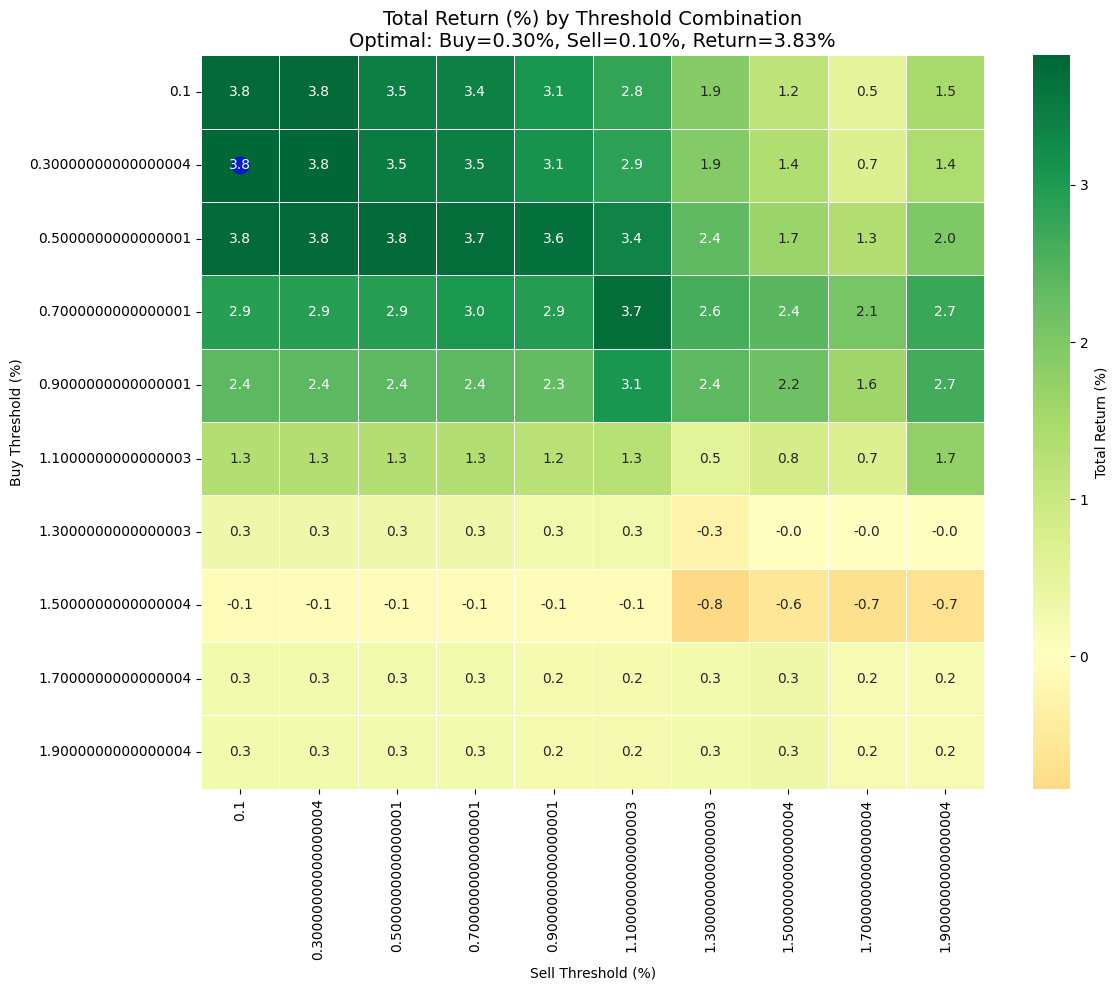

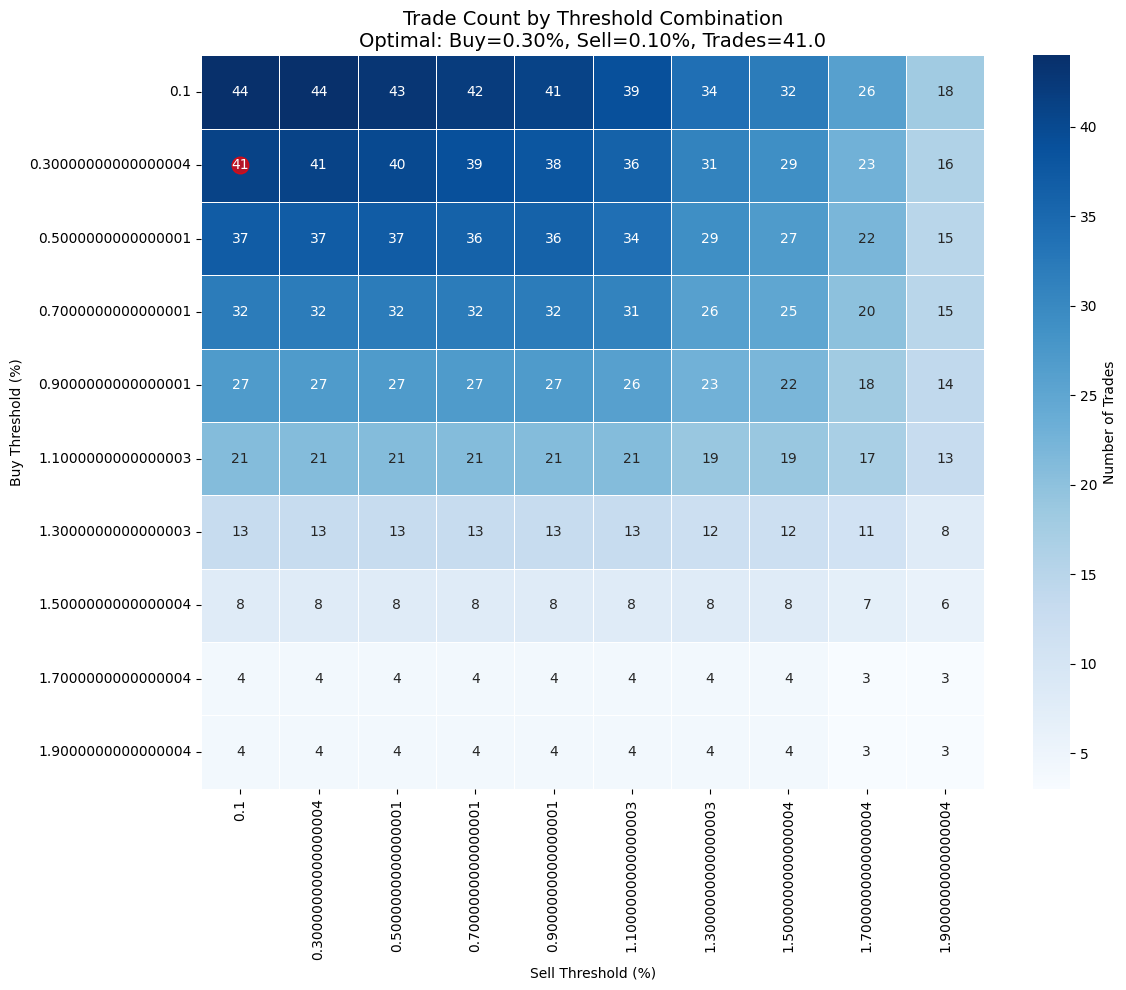

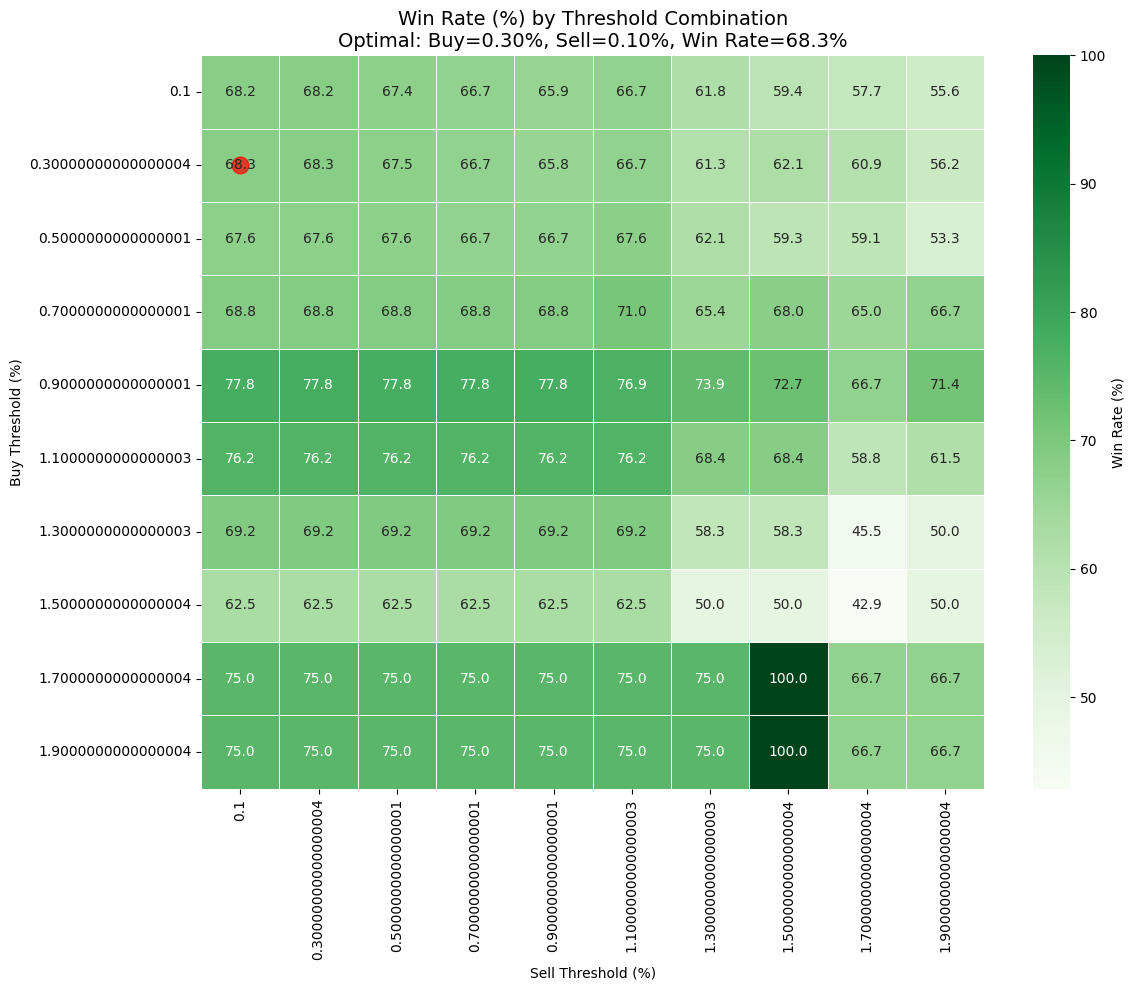

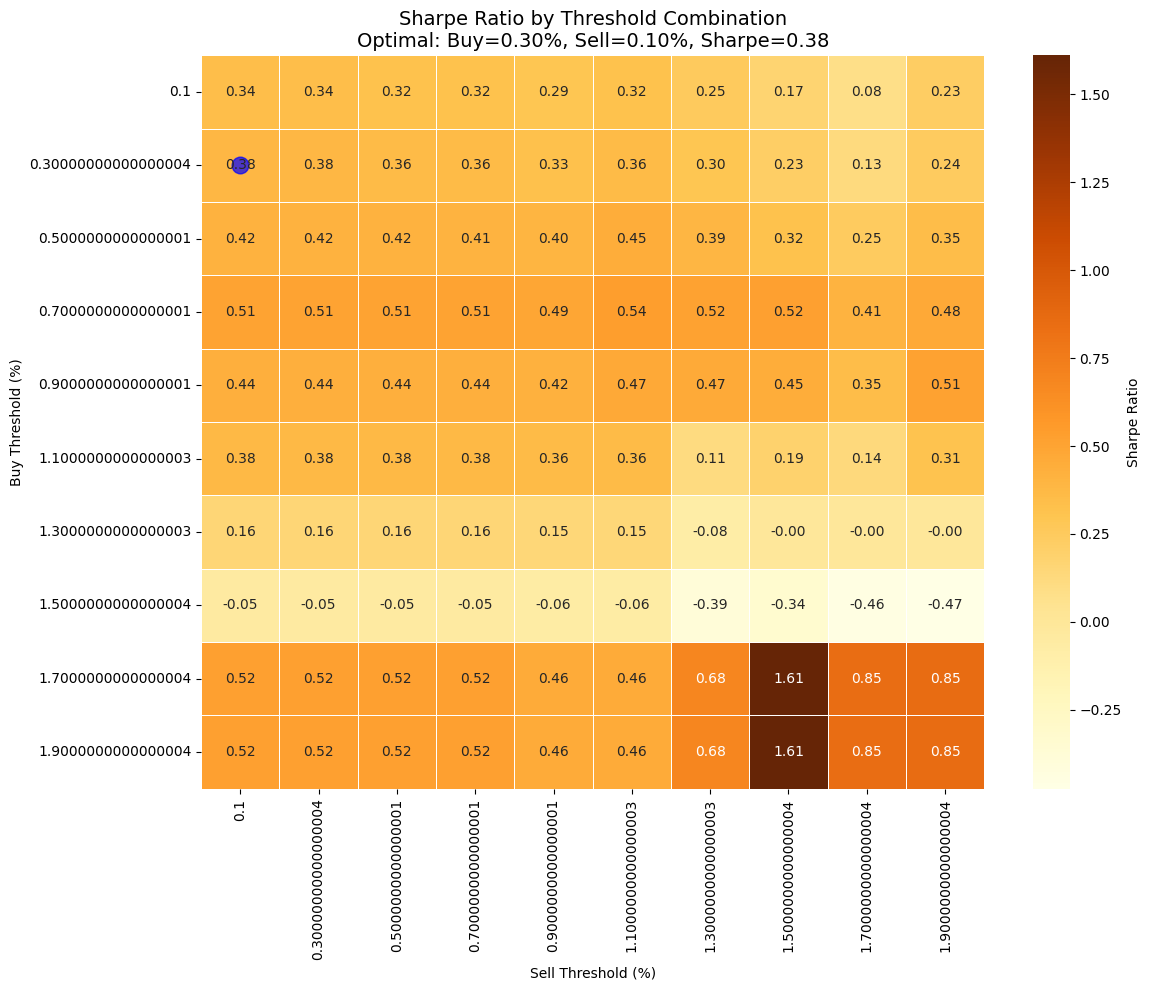

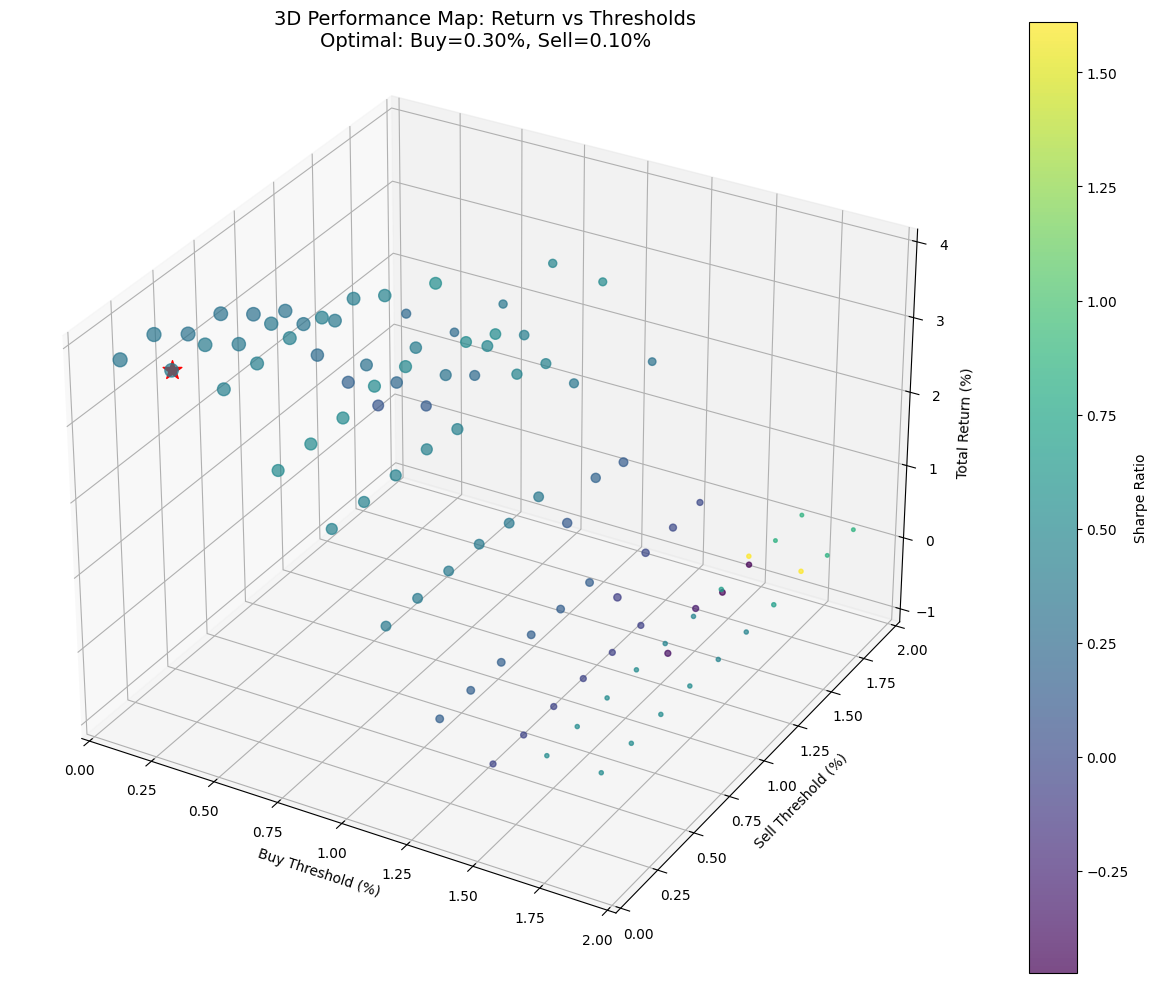

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from pathlib import Path
import datetime
import itertools
from tqdm import tqdm
import time

# Configuration
OUTPUT_DIR = "./output/model_results"
BACKTEST_OUTPUT_DIR = "./output/backtest_results"
Path(BACKTEST_OUTPUT_DIR).mkdir(parents=True, exist_ok=True)
Path(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization").mkdir(parents=True, exist_ok=True)

# Paths to model prediction files 
BUY_PREDICTIONS_PATH = f"{OUTPUT_DIR}/buy_model_predictions_test2.csv"
SELL_PREDICTIONS_PATH = f"{OUTPUT_DIR}/sell_model_predictions_test2.csv"

# Initial capital and position size
INITIAL_CAPITAL = 10000
POSITION_SIZE = 1  # Use 100% of capital per trade

print("=" * 80)
print("BSPoint Threshold Optimization: Finding Optimal Buy/Sell Thresholds")
print("=" * 80)

# Load predictions from models
print("\n[1/5] Loading model predictions...")
try:
    df_buy = pd.read_csv(BUY_PREDICTIONS_PATH)
    df_sell = pd.read_csv(SELL_PREDICTIONS_PATH)
    print(f"Loaded {len(df_buy)} buy signals and {len(df_sell)} sell signals")
    
    # Check if data is available
    if len(df_buy) == 0 and len(df_sell) == 0:
        raise ValueError("No prediction data found in either buy or sell files")
except FileNotFoundError:
    print("Prediction files not found. Make sure to run the model training script first.")
    raise

# Combine buy and sell predictions for convenience, adding a 'direction' column
df_buy['direction'] = 'buy'
df_sell['direction'] = 'sell'
df_signals = pd.concat([df_buy, df_sell], ignore_index=True)

# Convert timestamp to datetime for better sorting
if 'timestamp' in df_signals.columns:
    df_signals['timestamp'] = pd.to_datetime(df_signals['timestamp'])

# Sort signals chronologically by timestamp or klu_idx to ensure proper order
if 'timestamp' in df_signals.columns:
    df_signals = df_signals.sort_values('timestamp').reset_index(drop=True)
else:
    df_signals = df_signals.sort_values('klu_idx').reset_index(drop=True)

# Extract time range for the test period
if 'timestamp' in df_signals.columns:
    test_start = df_signals['timestamp'].min()
    test_end = df_signals['timestamp'].max()
    print(f"Test period: {test_start} to {test_end}")
else:
    test_start_idx = df_signals['klu_idx'].min()
    test_end_idx = df_signals['klu_idx'].max()
    print(f"Test period klu_idx range: {test_start_idx} to {test_end_idx}")

# Prepare the full dataset for buy & hold comparison
print("\n[2/5] Preparing price series for comparison...")

# Create a combined price series from the test data
all_test_data = df_signals.copy()

# Use klu_idx or timestamp as index, depending on what's available
if 'timestamp' in all_test_data.columns:
    all_test_data = all_test_data.sort_values('timestamp').drop_duplicates('timestamp')
    print(f"Unique price points in test period: {len(all_test_data)}")
else:
    all_test_data = all_test_data.sort_values('klu_idx').drop_duplicates('klu_idx')
    print(f"Unique price points in test period: {len(all_test_data)}")

# Calculate Buy & Hold for the entire test period
bh_entry_price = all_test_data.iloc[0]['klu_close']
bh_shares = INITIAL_CAPITAL / bh_entry_price
bh_final_price = all_test_data.iloc[-1]['klu_close']
bh_final_value = bh_shares * bh_final_price
bh_total_return = ((bh_final_value / INITIAL_CAPITAL) - 1) * 100

print(f"Buy & Hold return: {bh_total_return:.2f}%")

# Define the backtest function
def backtest_strategy(buy_threshold, sell_threshold, verbose=False):
    """
    Run a backtest with the specified buy and sell thresholds
    Returns a dictionary of performance metrics
    """
    # ML Strategy Portfolio
    ml_capital = INITIAL_CAPITAL
    ml_cash = INITIAL_CAPITAL
    ml_shares = 0  # Number of shares held
    ml_entry_price = 0
    ml_trades = []
    ml_returns = []
    ml_skipped_sells = 0  # Track skipped sell signals
    ml_skipped_buys = 0   # Track skipped buy signals

    # Process ML signals using separate model predictions
    for idx, row in df_signals.iterrows():
        current_price = row['klu_close']
        predicted_profit = row['predicted_profit_pct']
        actual_profit = row['profit_target_pct']
        direction = row['direction']
        timestamp = row['timestamp'] if 'timestamp' in row else None
        klu_idx = row['klu_idx']
        
        # === ML Strategy Logic ===
        if direction == 'buy' and ml_shares == 0:
            # BUY signal: Enter position if buy model predicts profit > buy threshold
            if predicted_profit >= buy_threshold:
                trade_capital = ml_cash * POSITION_SIZE
                ml_shares = trade_capital / current_price
                ml_entry_price = current_price
                ml_cash -= trade_capital
                
                ml_trades.append({
                    'entry_idx': idx,
                    'entry_klu_idx': klu_idx,
                    'entry_timestamp': timestamp,
                    'direction': 'buy',
                    'entry_price': current_price,
                    'predicted_profit': predicted_profit,
                    'position_size': trade_capital,
                    'shares': ml_shares,
                    'model_used': 'buy_model'
                })
            else:
                ml_skipped_buys += 1
        
        elif direction == 'sell' and ml_shares > 0:
            # SELL signal: Exit position if sell model predicts profit > sell threshold
            if predicted_profit >= sell_threshold:
                exit_value = ml_shares * current_price
                trade_profit = exit_value - (ml_shares * ml_entry_price)
                trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
                
                ml_cash += exit_value
                
                # Record trade result
                if ml_trades:
                    ml_trades[-1].update({
                        'exit_idx': idx,
                        'exit_klu_idx': klu_idx,
                        'exit_timestamp': timestamp,
                        'exit_price': current_price,
                        'exit_predicted_profit': predicted_profit,
                        'actual_profit': actual_profit,
                        'trade_profit': trade_profit,
                        'trade_return_pct': trade_return_pct,
                        'model_used_exit': 'sell_model'
                    })
                    ml_returns.append(trade_return_pct)
                
                # Reset position
                ml_shares = 0
                ml_entry_price = 0
            else:
                # Skip this sell signal (sell model predicts insufficient profit)
                ml_skipped_sells += 1

    # Close any open position at the end
    if ml_shares > 0:
        final_price = df_signals.iloc[-1]['klu_close']
        exit_value = ml_shares * final_price
        trade_profit = exit_value - (ml_shares * ml_entry_price)
        trade_return_pct = (trade_profit / (ml_shares * ml_entry_price)) * 100
        
        ml_cash += exit_value
        
        if ml_trades:
            ml_trades[-1].update({
                'exit_idx': len(df_signals) - 1,
                'exit_klu_idx': df_signals.iloc[-1]['klu_idx'] if 'klu_idx' in df_signals.iloc[-1] else None,
                'exit_timestamp': df_signals.iloc[-1]['timestamp'] if 'timestamp' in df_signals.iloc[-1] else None,
                'exit_price': final_price,
                'exit_predicted_profit': None,
                'actual_profit': None,
                'trade_profit': trade_profit,
                'trade_return_pct': trade_return_pct,
                'note': 'Closed at end of period'
            })
            ml_returns.append(trade_return_pct)

    # Calculate final metrics
    ml_final_value = ml_cash
    ml_total_return = ((ml_final_value / INITIAL_CAPITAL) - 1) * 100

    # Max Drawdown
    ml_peak = INITIAL_CAPITAL
    ml_max_drawdown = 0
    ml_equity_curve = []
    
    for trade in ml_trades:
        if 'trade_profit' in trade:
            ml_equity_curve.append(trade['trade_profit'])
            
    if ml_equity_curve:
        cumulative = INITIAL_CAPITAL
        curve = [cumulative]
        
        for profit in ml_equity_curve:
            cumulative += profit
            curve.append(cumulative)
            ml_peak = max(ml_peak, cumulative)
            drawdown = (ml_peak - cumulative) / ml_peak * 100
            ml_max_drawdown = max(ml_max_drawdown, drawdown)

    # Trade statistics
    ml_completed_trades = sum(1 for trade in ml_trades if 'exit_price' in trade)
    ml_winning_trades = sum(1 for trade in ml_trades if 'trade_return_pct' in trade and trade['trade_return_pct'] > 0)
    ml_win_rate = (ml_winning_trades / ml_completed_trades * 100) if ml_completed_trades > 0 else 0
    
    # Calculate average trade return
    avg_return = np.mean(ml_returns) if ml_returns else 0
    
    # Calculate Sharpe Ratio (approximated)
    sharpe_ratio = 0
    if len(ml_returns) > 1:
        sharpe_ratio = np.mean(ml_returns) / (np.std(ml_returns) if np.std(ml_returns) > 0 else 1)
    
    # Print results if verbose
    if verbose:
        print(f"\nBuy Threshold: {buy_threshold}%, Sell Threshold: {sell_threshold}%")
        print(f"Final Value: ${ml_final_value:,.2f}, Total Return: {ml_total_return:.2f}%")
        print(f"Trades: {ml_completed_trades}, Win Rate: {ml_win_rate:.1f}%")
        print(f"Max Drawdown: {ml_max_drawdown:.2f}%, Avg Return/Trade: {avg_return:.2f}%")
    
    return {
        'buy_threshold': buy_threshold,
        'sell_threshold': sell_threshold,
        'final_value': ml_final_value,
        'total_return': ml_total_return,
        'max_drawdown': ml_max_drawdown,
        'trades': ml_completed_trades,
        'win_rate': ml_win_rate,
        'avg_trade_return': avg_return,
        'sharpe_ratio': sharpe_ratio,
        'skipped_buys': ml_skipped_buys,
        'skipped_sells': ml_skipped_sells,
        'vs_bh': ml_total_return - bh_total_return
    }

# Define the optimization ranges
def optimize_thresholds(verbose=True):
    """
    Run a grid search to find optimal thresholds
    Returns a dataframe of results and the optimal thresholds
    """
    # Set the search grid
    buy_thresholds = np.arange(0.1, 2.1, 0.2)  # From 0.1% to 2.0% in 0.2% steps
    sell_thresholds = np.arange(0.1, 2.1, 0.2)  # From 0.1% to 2.0% in 0.2% steps
    
    # Create all combinations
    combinations = list(itertools.product(buy_thresholds, sell_thresholds))
    total_combinations = len(combinations)
    
    print(f"\n[3/5] Running grid search over {total_combinations} threshold combinations...")
    print(f"Buy thresholds: {buy_thresholds}")
    print(f"Sell thresholds: {sell_thresholds}")
    
    # Track results
    results = []
    
    # Progress tracking
    start_time = time.time()
    
    # Run backtests with progress bar
    for i, (buy_threshold, sell_threshold) in enumerate(tqdm(combinations, desc="Testing Thresholds")):
        # Run backtest
        result = backtest_strategy(buy_threshold, sell_threshold)
        
        # Store result
        results.append(result)
        
        # Show progress every 10% if verbose
        if verbose and (i+1) % max(1, total_combinations // 10) == 0:
            elapsed = time.time() - start_time
            estimated_total = elapsed / (i+1) * total_combinations
            remaining = max(0, estimated_total - elapsed)
            
            print(f"Progress: {i+1}/{total_combinations} combinations tested")
            print(f"Elapsed: {elapsed:.1f}s, Estimated remaining: {remaining:.1f}s")
            
            # Show current best
            if results:
                best_idx = np.argmax([r['total_return'] for r in results[:i+1]])
                best = results[best_idx]
                print(f"Current best: Buy={best['buy_threshold']:.1f}%, Sell={best['sell_threshold']:.1f}%, " +
                      f"Return={best['total_return']:.2f}%, Trades={best['trades']}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Find the optimal thresholds based on total return
    best_idx = results_df['total_return'].idxmax()
    best_result = results_df.iloc[best_idx].to_dict()
    
    return results_df, best_result

# Run the optimization
print("\n[3/5] Starting threshold optimization...")
results_df, best_result = optimize_thresholds()

# Display detailed results for the optimal thresholds
print("\n[4/5] Running detailed backtest with optimal thresholds...")
optimal_buy = best_result['buy_threshold']
optimal_sell = best_result['sell_threshold']

# Run detailed backtest with optimal thresholds
print(f"\nRunning detailed backtest with Buy={optimal_buy:.2f}%, Sell={optimal_sell:.2f}%")
detailed_result = backtest_strategy(optimal_buy, optimal_sell, verbose=True)

print("\n" + "=" * 80)
print(f"OPTIMAL THRESHOLDS FOUND")
print("=" * 80)
print(f"Buy Threshold:  {optimal_buy:.2f}%")
print(f"Sell Threshold: {optimal_sell:.2f}%")
print(f"Total Return:   {detailed_result['total_return']:.2f}%")
print(f"vs Buy & Hold:  {detailed_result['vs_bh']:+.2f}%")
print(f"Trades:         {detailed_result['trades']}")
print(f"Win Rate:       {detailed_result['win_rate']:.1f}%")
print(f"Avg Return:     {detailed_result['avg_trade_return']:.2f}% per trade")
print(f"Max Drawdown:   {detailed_result['max_drawdown']:.2f}%")
print(f"Sharpe Ratio:   {detailed_result['sharpe_ratio']:.2f}")

# Visualize the results
print("\n[5/5] Creating visualizations...")

# Create a pivot table for heatmap
pivot_data = results_df.pivot_table(index='buy_threshold', columns='sell_threshold', values='total_return')

# 1. Returns Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_data, annot=True, fmt=".1f", cmap="RdYlGn", center=0, 
            linewidths=.5, cbar_kws={"label": "Total Return (%)"})
plt.title(f"Total Return (%) by Threshold Combination\nOptimal: Buy={optimal_buy:.2f}%, Sell={optimal_sell:.2f}%, Return={best_result['total_return']:.2f}%",
         fontsize=14)
plt.xlabel("Sell Threshold (%)")
plt.ylabel("Buy Threshold (%)")

# Mark the optimal threshold
best_row = np.where(pivot_data.index == optimal_buy)[0][0]
best_col = np.where(pivot_data.columns == optimal_sell)[0][0]
plt.plot(best_col + 0.5, best_row + 0.5, 'o', markersize=12, color='blue', alpha=0.7)

plt.tight_layout()
plt.savefig(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization/returns_heatmap.png", dpi=150, bbox_inches='tight')
print(f"Saved: {BACKTEST_OUTPUT_DIR}/threshold_optimization/returns_heatmap.png")

# 2. Trade Count Heatmap
pivot_trades = results_df.pivot_table(index='buy_threshold', columns='sell_threshold', values='trades')
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_trades, annot=True, fmt=".0f", cmap="Blues", 
            linewidths=.5, cbar_kws={"label": "Number of Trades"})
plt.title(f"Trade Count by Threshold Combination\nOptimal: Buy={optimal_buy:.2f}%, Sell={optimal_sell:.2f}%, Trades={best_result['trades']}",
         fontsize=14)
plt.xlabel("Sell Threshold (%)")
plt.ylabel("Buy Threshold (%)")

# Mark the optimal threshold
plt.plot(best_col + 0.5, best_row + 0.5, 'o', markersize=12, color='red', alpha=0.7)

plt.tight_layout()
plt.savefig(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization/trades_heatmap.png", dpi=150, bbox_inches='tight')
print(f"Saved: {BACKTEST_OUTPUT_DIR}/threshold_optimization/trades_heatmap.png")

# 3. Win Rate Heatmap
pivot_winrate = results_df.pivot_table(index='buy_threshold', columns='sell_threshold', values='win_rate')
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_winrate, annot=True, fmt=".1f", cmap="Greens", 
            linewidths=.5, cbar_kws={"label": "Win Rate (%)"})
plt.title(f"Win Rate (%) by Threshold Combination\nOptimal: Buy={optimal_buy:.2f}%, Sell={optimal_sell:.2f}%, Win Rate={best_result['win_rate']:.1f}%",
         fontsize=14)
plt.xlabel("Sell Threshold (%)")
plt.ylabel("Buy Threshold (%)")

# Mark the optimal threshold
plt.plot(best_col + 0.5, best_row + 0.5, 'o', markersize=12, color='red', alpha=0.7)

plt.tight_layout()
plt.savefig(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization/winrate_heatmap.png", dpi=150, bbox_inches='tight')
print(f"Saved: {BACKTEST_OUTPUT_DIR}/threshold_optimization/winrate_heatmap.png")

# 4. Sharpe Ratio Heatmap
pivot_sharpe = results_df.pivot_table(index='buy_threshold', columns='sell_threshold', values='sharpe_ratio')
plt.figure(figsize=(12, 10))
sns.heatmap(pivot_sharpe, annot=True, fmt=".2f", cmap="YlOrBr", 
            linewidths=.5, cbar_kws={"label": "Sharpe Ratio"})
plt.title(f"Sharpe Ratio by Threshold Combination\nOptimal: Buy={optimal_buy:.2f}%, Sell={optimal_sell:.2f}%, Sharpe={best_result['sharpe_ratio']:.2f}",
         fontsize=14)
plt.xlabel("Sell Threshold (%)")
plt.ylabel("Buy Threshold (%)")

# Mark the optimal threshold
plt.plot(best_col + 0.5, best_row + 0.5, 'o', markersize=12, color='blue', alpha=0.7)

plt.tight_layout()
plt.savefig(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization/sharpe_heatmap.png", dpi=150, bbox_inches='tight')
print(f"Saved: {BACKTEST_OUTPUT_DIR}/threshold_optimization/sharpe_heatmap.png")

# 5. Combined Performance Plot
# Create a 3D scatter plot to show multiple dimensions
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get data for plotting
x = results_df['buy_threshold']
y = results_df['sell_threshold']
z = results_df['total_return']
colors = results_df['sharpe_ratio']
sizes = results_df['trades'] / results_df['trades'].max() * 100

# Create the scatter plot
scatter = ax.scatter(x, y, z, c=colors, s=sizes, cmap='viridis', alpha=0.7)

# Mark the optimal point
ax.scatter([optimal_buy], [optimal_sell], [best_result['total_return']], 
           color='red', s=200, marker='*')

# Add labels
ax.set_xlabel('Buy Threshold (%)')
ax.set_ylabel('Sell Threshold (%)')
ax.set_zlabel('Total Return (%)')

# Add a color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Sharpe Ratio')

# Add title
plt.title(f'3D Performance Map: Return vs Thresholds\nOptimal: Buy={optimal_buy:.2f}%, Sell={optimal_sell:.2f}%',
         fontsize=14, y=1.05)

plt.tight_layout()
plt.savefig(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization/3d_performance.png", dpi=150, bbox_inches='tight')
print(f"Saved: {BACKTEST_OUTPUT_DIR}/threshold_optimization/3d_performance.png")

# Save results to CSV
results_df.to_csv(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization/optimization_results.csv", index=False)
print(f"Saved: {BACKTEST_OUTPUT_DIR}/threshold_optimization/optimization_results.csv")

# Create summary report
with open(f"{BACKTEST_OUTPUT_DIR}/threshold_optimization/optimization_summary.txt", 'w') as f:
    f.write("BSPoint Threshold Optimization Summary\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("OPTIMIZATION PARAMETERS:\n")
    f.write(f"  Buy Thresholds Tested:  {min(results_df['buy_threshold']):.1f}% to {max(results_df['buy_threshold']):.1f}%\n")
    f.write(f"  Sell Thresholds Tested: {min(results_df['sell_threshold']):.1f}% to {max(results_df['sell_threshold']):.1f}%\n")
    f.write(f"  Total Combinations:     {len(results_df)}\n")
    f.write(f"  Position Size:          {POSITION_SIZE*100}%\n")
    f.write(f"  Initial Capital:        ${INITIAL_CAPITAL:,.2f}\n\n")
    
    f.write("OPTIMAL THRESHOLDS:\n")
    f.write(f"  Buy Threshold:  {optimal_buy:.2f}%\n")
    f.write(f"  Sell Threshold: {optimal_sell:.2f}%\n\n")
    
    f.write("PERFORMANCE WITH OPTIMAL THRESHOLDS:\n")
    f.write(f"  Total Return:         {best_result['total_return']:.2f}%\n")
    f.write(f"  vs Buy & Hold:        {best_result['vs_bh']:+.2f}%\n")
    f.write(f"  Sharpe Ratio:         {best_result['sharpe_ratio']:.2f}\n")
    f.write(f"  Max Drawdown:         {best_result['max_drawdown']:.2f}%\n")
    f.write(f"  Total Trades:         {best_result['trades']}\n")
    f.write(f"  Win Rate:             {best_result['win_rate']:.1f}%\n")
    f.write(f"  Average Trade Return: {best_result['avg_trade_return']:.2f}%\n")
    f.write(f"  Skipped Buy Signals:  {best_result['skipped_buys']}\n")
    f.write(f"  Skipped Sell Signals: {best_result['skipped_sells']}\n\n")
    
    f.write("BUY & HOLD PERFORMANCE:\n")
    f.write(f"  Entry Price: ${bh_entry_price:.2f}\n")
    f.write(f"  Final Price: ${bh_final_price:.2f}\n")
    f.write(f"  Total Return: {bh_total_return:.2f}%\n\n")
    
    # Add top 5 best performing combinations
    f.write("TOP 5 BEST PERFORMING THRESHOLD COMBINATIONS:\n")
    top5 = results_df.sort_values('total_return', ascending=False).head(5)
    for i, row in top5.iterrows():
        f.write(f"  {i+1}. Buy={row['buy_threshold']:.2f}%, Sell={row['sell_threshold']:.2f}%, " +
                f"Return={row['total_return']:.2f}%, Trades={row['trades']}, Win Rate={row['win_rate']:.1f}%\n")

print(f"Saved: {BACKTEST_OUTPUT_DIR}/threshold_optimization/optimization_summary.txt")

# Copy visualizations to the outputs folder for download
import os
os.makedirs("/mnt/user-data/outputs/threshold_optimization", exist_ok=True)
os.system(f"cp -r {BACKTEST_OUTPUT_DIR}/threshold_optimization/* /mnt/user-data/outputs/threshold_optimization/")

print("\n" + "=" * 80)
print("Threshold Optimization Complete!")
print("=" * 80)

print(f"\nOptimal Thresholds Found:")
print(f"  - Buy Threshold:  {optimal_buy:.2f}%")
print(f"  - Sell Threshold: {optimal_sell:.2f}%")
print(f"  - Total Return:   {best_result['total_return']:.2f}% ({best_result['vs_bh']:+.2f}% vs Buy & Hold)")
print(f"  - Trades:         {best_result['trades']} with {best_result['win_rate']:.1f}% win rate")

print(f"\n📈 All visualizations saved to: /mnt/user-data/outputs/threshold_optimization/")
print(f"📊 Full results saved to: {BACKTEST_OUTPUT_DIR}/threshold_optimization/optimization_results.csv")

# Run a final detailed backtest with the optimal thresholds
print("\nTo run a full backtest with these optimal thresholds, update your backtest script with:")
print(f"PROFIT_THRESHOLD_BUY = {optimal_buy:.2f}   # Optimal buy threshold")
print(f"PROFIT_THRESHOLD_SELL = {optimal_sell:.2f}  # Optimal sell threshold")

Sliding Window Model Training - Window Size: 20%, Increment: 5%

[1] Loading dataset...
Data shape: (30847, 79)
Date range: 2022-01-04 05:10:00 to 2024-12-31 14:40:00
Total data points: 30847
Number of sliding windows: 17
Features identified: 64

Processing Window 1/17 (0%-20%)
Window date range: 2022-01-04 to 2022-08-04
Window training data: 4719 samples
Window validation data: 833 samples
Window test1 data: 308 samples
Window test2 data: 309 samples

Training BUY model for window 1...
BUY MODEL METRICS (Window 1):
  Training:   R² = 0.9929, RMSE = 0.1091%, Acc = 98.65%
  Validation: R² = 0.8032, RMSE = 0.5752%, Acc = 93.06%
  Test1:      R² = -0.1683, RMSE = 0.9550%, Acc = 100.00%
  Test2:      R² = -0.8033, RMSE = 1.2813%, Acc = 93.57%

Training SELL model for window 1...
SELL MODEL METRICS (Window 1):
  Training:   R² = 0.9923, RMSE = 0.1149%, Acc = 98.38%
  Validation: R² = 0.6443, RMSE = 0.7774%, Acc = 94.26%
  Test1:      R² = -0.4291, RMSE = 1.6107%, Acc = 69.73%
  Test2:      

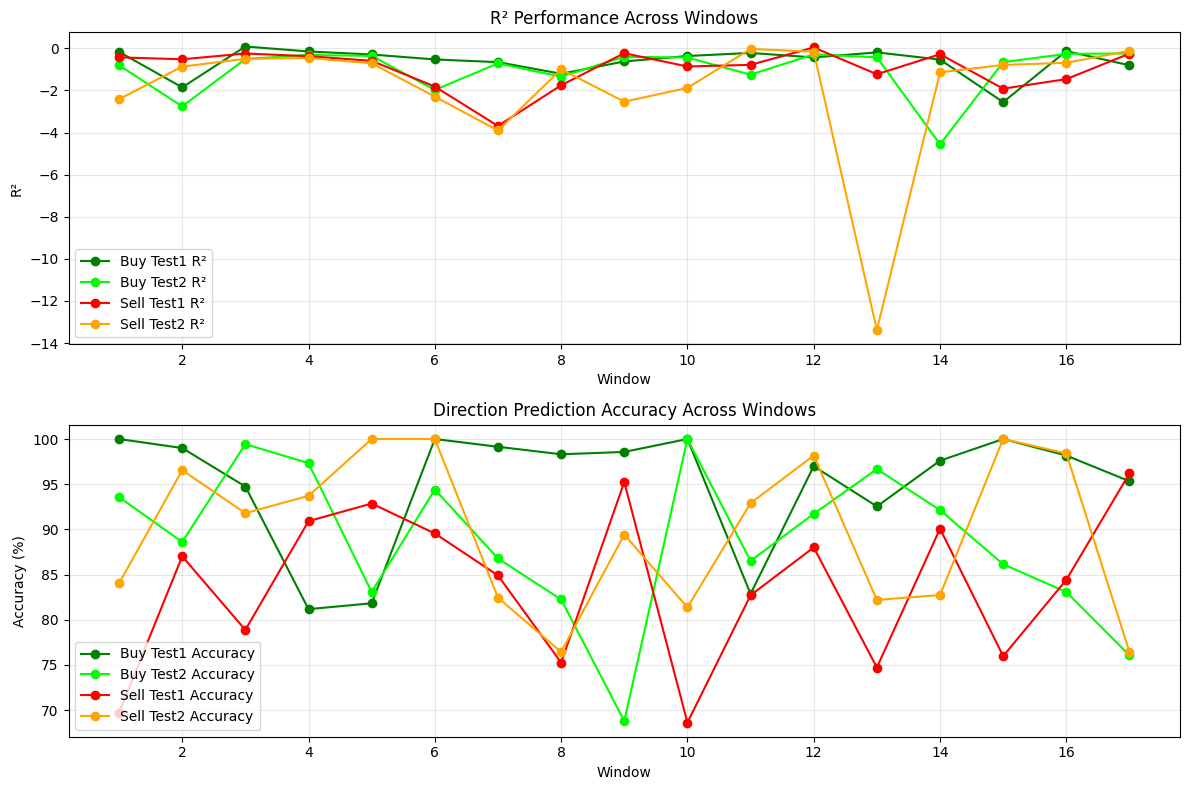

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import datetime
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

# Configuration
DATA_PATH = "./output/enhanced_bs_features/SPY_ml_training_dataset_22.1.1-24.12.31.csv"  # Path to your dataset
OUTPUT_DIR = "./output/sliding_window_results"
Path(OUTPUT_DIR).mkdir(parents=True, exist_ok=True)

# Sliding window configuration
WINDOW_SIZE = 0.20  # 20% of data per window
SLIDE_INCREMENT = 0.05  # 5% slide each time

# Split percentages within each window (same as original script)
TRAIN_VAL_PERCENT = 0.90   # 90% for training and validation
TEST1_PERCENT = 0.05       # 5% for test1
TEST2_PERCENT = 0.05       # 5% for test2
TRAIN_WITHIN_TRAINVAL = 0.85  # 85% of the train_val data for training
VAL_WITHIN_TRAINVAL = 0.15    # 15% of the train_val data for validation

print("=" * 80)
print(f"Sliding Window Model Training - Window Size: {WINDOW_SIZE*100:.0f}%, Increment: {SLIDE_INCREMENT*100:.0f}%")
print("=" * 80)

# Load dataset
print("\n[1] Loading dataset...")
df = pd.read_csv(DATA_PATH)
print(f"Data shape: {df.shape}")

# Convert timestamp to datetime if needed
if 'timestamp' in df.columns and not pd.api.types.is_datetime64_any_dtype(df['timestamp']):
    df['timestamp'] = pd.to_datetime(df['timestamp'])
print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")

# Sort by timestamp to ensure chronological order
df = df.sort_values('timestamp')

# Calculate the number of windows
total_rows = len(df)
num_windows = int((1.0 - WINDOW_SIZE) / SLIDE_INCREMENT) + 1
print(f"Total data points: {total_rows}")
print(f"Number of sliding windows: {num_windows}")

# Identify feature columns (same as original script)
exclude_patterns = ['timestamp', 'bsp_type', 'direction', 'profit_target', 
                   'has_profit', 'return_', 'label_', 'target_return_', 
                   'snapshot_', 'klu_idx', 'exit_']

feature_cols = [col for col in df.columns 
                if not any(pat in col for pat in exclude_patterns)]

# Remove encoded columns if original exists
if 'direction' in feature_cols and 'direction_encoded' in feature_cols:
    feature_cols.remove('direction')
if 'bsp_type' in feature_cols and 'bsp_type_encoded' in feature_cols:
    feature_cols.remove('bsp_type')

feature_cols = sorted(feature_cols)
print(f"Features identified: {len(feature_cols)}")

# Create a summary file
summary_file_path = f"{OUTPUT_DIR}/sliding_window_summary.txt"
with open(summary_file_path, 'w') as summary_file:
    summary_file.write(f"Sliding Window Analysis Summary\n")
    summary_file.write(f"==============================\n\n")
    summary_file.write(f"Window Size: {WINDOW_SIZE*100:.0f}%\n")
    summary_file.write(f"Slide Increment: {SLIDE_INCREMENT*100:.0f}%\n")
    summary_file.write(f"Number of Windows: {num_windows}\n\n")
    summary_file.write(f"Window | Date Range | Buy Test1 R² | Buy Test2 R² | Buy Test1 Acc | Buy Test2 Acc | Sell Test1 R² | Sell Test2 R² | Sell Test1 Acc | Sell Test2 Acc\n")
    summary_file.write(f"-------|------------|-------------|-------------|--------------|--------------|--------------|--------------|----------------|----------------\n")

# Function to calculate metrics (same as original script)
def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate accuracy (correct direction prediction)
    correct_direction = np.mean((y_true > 0) == (y_pred > 0)) * 100
    
    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Accuracy': correct_direction
    }

# Process each sliding window
for window_idx in range(num_windows):
    window_start_pct = window_idx * SLIDE_INCREMENT
    window_end_pct = window_start_pct + WINDOW_SIZE
    
    window_start_idx = int(total_rows * window_start_pct)
    window_end_idx = int(total_rows * window_end_pct)
    
    # Extract the current window data
    window_df = df.iloc[window_start_idx:window_end_idx].copy()
    
    print("\n" + "=" * 80)
    print(f"Processing Window {window_idx+1}/{num_windows} ({window_start_pct*100:.0f}%-{window_end_pct*100:.0f}%)")
    print("=" * 80)
    
    window_dir = f"{OUTPUT_DIR}/window_{window_idx+1}"
    Path(window_dir).mkdir(parents=True, exist_ok=True)
    
    # Get date range for this window
    start_date = window_df['timestamp'].min().strftime('%Y-%m-%d')
    end_date = window_df['timestamp'].max().strftime('%Y-%m-%d')
    print(f"Window date range: {start_date} to {end_date}")
    
    # Within the window, apply the same splitting logic as the original script
    window_total_rows = len(window_df)
    train_val_end_idx = int(window_total_rows * TRAIN_VAL_PERCENT)
    test1_end_idx = int(window_total_rows * (TRAIN_VAL_PERCENT + TEST1_PERCENT))
    
    # Split window into train_val, test1, and test2
    train_val_df = window_df.iloc[:train_val_end_idx].copy()
    test1_df = window_df.iloc[train_val_end_idx:test1_end_idx].copy()
    test2_df = window_df.iloc[test1_end_idx:].copy()
    
    # Randomly split train_val data into train and validation
    train_df, validation_df = train_test_split(
        train_val_df, 
        test_size=VAL_WITHIN_TRAINVAL,
        random_state=42
    )
    
    print(f"Window training data: {len(train_df)} samples")
    print(f"Window validation data: {len(validation_df)} samples")
    print(f"Window test1 data: {len(test1_df)} samples")
    print(f"Window test2 data: {len(test2_df)} samples")
    
    # Split data by direction (same as original script)
    train_valid = train_df[train_df['has_profit_target'] == 1].copy()
    train_buy = train_valid[train_valid['direction'] == 'buy'].copy()
    train_sell = train_valid[train_valid['direction'] == 'sell'].copy()
    
    val_valid = validation_df[validation_df['has_profit_target'] == 1].copy()
    val_buy = val_valid[val_valid['direction'] == 'buy'].copy()
    val_sell = val_valid[val_valid['direction'] == 'sell'].copy()
    
    test1_valid = test1_df[test1_df['has_profit_target'] == 1].copy()
    test1_buy = test1_valid[test1_valid['direction'] == 'buy'].copy()
    test1_sell = test1_valid[test1_valid['direction'] == 'sell'].copy()
    
    test2_valid = test2_df[test2_df['has_profit_target'] == 1].copy()
    test2_buy = test2_valid[test2_valid['direction'] == 'buy'].copy()
    test2_sell = test2_valid[test2_valid['direction'] == 'sell'].copy()
    
    # Prepare data for model training
    # Buy model data
    X_train_buy = train_buy[feature_cols].fillna(0)
    y_train_buy = train_buy['profit_target_pct']
    
    X_val_buy = val_buy[feature_cols].fillna(0)
    y_val_buy = val_buy['profit_target_pct']
    
    X_test1_buy = test1_buy[feature_cols].fillna(0)
    y_test1_buy = test1_buy['profit_target_pct']
    
    X_test2_buy = test2_buy[feature_cols].fillna(0)
    y_test2_buy = test2_buy['profit_target_pct']
    
    # Sell model data
    X_train_sell = train_sell[feature_cols].fillna(0)
    y_train_sell = train_sell['profit_target_pct']
    
    X_val_sell = val_sell[feature_cols].fillna(0)
    y_val_sell = val_sell['profit_target_pct']
    
    X_test1_sell = test1_sell[feature_cols].fillna(0)
    y_test1_sell = test1_sell['profit_target_pct']
    
    X_test2_sell = test2_sell[feature_cols].fillna(0)
    y_test2_sell = test2_sell['profit_target_pct']
    
    # Model parameters (same as original script)
    params = {
        'max_depth': 6,
        'learning_rate': 0.1,
        'n_estimators': 300,
        'random_state': 42
    }
    
    # Train and evaluate buy model
    buy_model_trained = False
    buy_test1_metrics = None
    buy_test2_metrics = None
    
    if len(X_train_buy) > 10:  # Only train if we have enough samples
        print(f"\nTraining BUY model for window {window_idx+1}...")
        model_buy = xgb.XGBRegressor(**params)
        model_buy.fit(X_train_buy, y_train_buy)
        buy_model_trained = True
        
        # Make predictions
        y_train_buy_pred = model_buy.predict(X_train_buy)
        y_val_buy_pred = model_buy.predict(X_val_buy)
        y_test1_buy_pred = model_buy.predict(X_test1_buy)
        y_test2_buy_pred = model_buy.predict(X_test2_buy)
        
        # Calculate metrics
        buy_train_metrics = calculate_metrics(y_train_buy, y_train_buy_pred)
        buy_val_metrics = calculate_metrics(y_val_buy, y_val_buy_pred)
        buy_test1_metrics = calculate_metrics(y_test1_buy, y_test1_buy_pred)
        buy_test2_metrics = calculate_metrics(y_test2_buy, y_test2_buy_pred)
        
        print(f"BUY MODEL METRICS (Window {window_idx+1}):")
        print(f"  Training:   R² = {buy_train_metrics['R2']:.4f}, RMSE = {buy_train_metrics['RMSE']:.4f}%, Acc = {buy_train_metrics['Accuracy']:.2f}%")
        print(f"  Validation: R² = {buy_val_metrics['R2']:.4f}, RMSE = {buy_val_metrics['RMSE']:.4f}%, Acc = {buy_val_metrics['Accuracy']:.2f}%")
        print(f"  Test1:      R² = {buy_test1_metrics['R2']:.4f}, RMSE = {buy_test1_metrics['RMSE']:.4f}%, Acc = {buy_test1_metrics['Accuracy']:.2f}%")
        print(f"  Test2:      R² = {buy_test2_metrics['R2']:.4f}, RMSE = {buy_test2_metrics['RMSE']:.4f}%, Acc = {buy_test2_metrics['Accuracy']:.2f}%")
        
        # Save buy model
        model_buy.save_model(f"{window_dir}/xgboost_buy_model.json")
        
        # Feature importance
        importance_buy = model_buy.feature_importances_
        feature_importance_buy = pd.DataFrame({
            'feature': feature_cols,
            'importance': importance_buy
        })
        feature_importance_buy = feature_importance_buy.sort_values('importance', ascending=False)
        feature_importance_buy.to_csv(f"{window_dir}/buy_model_feature_importance.csv", index=False)
    else:
        print(f"Not enough buy samples in window {window_idx+1} to train model")
    
    # Train and evaluate sell model
    sell_model_trained = False
    sell_test1_metrics = None
    sell_test2_metrics = None
    
    if len(X_train_sell) > 10:  # Only train if we have enough samples
        print(f"\nTraining SELL model for window {window_idx+1}...")
        model_sell = xgb.XGBRegressor(**params)
        model_sell.fit(X_train_sell, y_train_sell)
        sell_model_trained = True
        
        # Make predictions
        y_train_sell_pred = model_sell.predict(X_train_sell)
        y_val_sell_pred = model_sell.predict(X_val_sell)
        y_test1_sell_pred = model_sell.predict(X_test1_sell)
        y_test2_sell_pred = model_sell.predict(X_test2_sell)
        
        # Calculate metrics
        sell_train_metrics = calculate_metrics(y_train_sell, y_train_sell_pred)
        sell_val_metrics = calculate_metrics(y_val_sell, y_val_sell_pred)
        sell_test1_metrics = calculate_metrics(y_test1_sell, y_test1_sell_pred)
        sell_test2_metrics = calculate_metrics(y_test2_sell, y_test2_sell_pred)
        
        print(f"SELL MODEL METRICS (Window {window_idx+1}):")
        print(f"  Training:   R² = {sell_train_metrics['R2']:.4f}, RMSE = {sell_train_metrics['RMSE']:.4f}%, Acc = {sell_train_metrics['Accuracy']:.2f}%")
        print(f"  Validation: R² = {sell_val_metrics['R2']:.4f}, RMSE = {sell_val_metrics['RMSE']:.4f}%, Acc = {sell_val_metrics['Accuracy']:.2f}%")
        print(f"  Test1:      R² = {sell_test1_metrics['R2']:.4f}, RMSE = {sell_test1_metrics['RMSE']:.4f}%, Acc = {sell_test1_metrics['Accuracy']:.2f}%")
        print(f"  Test2:      R² = {sell_test2_metrics['R2']:.4f}, RMSE = {sell_test2_metrics['RMSE']:.4f}%, Acc = {sell_test2_metrics['Accuracy']:.2f}%")
        
        # Save sell model
        model_sell.save_model(f"{window_dir}/xgboost_sell_model.json")
        
        # Feature importance
        importance_sell = model_sell.feature_importances_
        feature_importance_sell = pd.DataFrame({
            'feature': feature_cols,
            'importance': importance_sell
        })
        feature_importance_sell = feature_importance_sell.sort_values('importance', ascending=False)
        feature_importance_sell.to_csv(f"{window_dir}/sell_model_feature_importance.csv", index=False)
    else:
        print(f"Not enough sell samples in window {window_idx+1} to train model")
    
    # Create visualizations for each window's models
    if buy_model_trained:
        # Create a 3x2 grid for the buy model
        plt.figure(figsize=(15, 18))
        gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1])
        
        # Training scatter plot
        ax1 = plt.subplot(gs[0, 0])
        ax1.scatter(y_train_buy, y_train_buy_pred, alpha=0.6, s=25)
        ax1.plot([y_train_buy.min(), y_train_buy.max()], 
                 [y_train_buy.min(), y_train_buy.max()], 'r--', lw=2)
        ax1.set_title(f'Training Set\nR²={buy_train_metrics["R2"]:.3f}')
        ax1.set_xlabel('Actual Profit %')
        ax1.set_ylabel('Predicted Profit %')
        ax1.grid(True, alpha=0.3)
        
        # Validation scatter plot
        ax2 = plt.subplot(gs[0, 1])
        ax2.scatter(y_val_buy, y_val_buy_pred, alpha=0.6, s=25)
        ax2.plot([y_val_buy.min(), y_val_buy.max()], 
                 [y_val_buy.min(), y_val_buy.max()], 'r--', lw=2)
        ax2.set_title(f'Validation Set\nR²={buy_val_metrics["R2"]:.3f}')
        ax2.set_xlabel('Actual Profit %')
        ax2.set_ylabel('Predicted Profit %')
        ax2.grid(True, alpha=0.3)
        
        # Test1 scatter plot
        ax3 = plt.subplot(gs[1, 0])
        ax3.scatter(y_test1_buy, y_test1_buy_pred, alpha=0.6, s=25, color='green')
        ax3.plot([y_test1_buy.min(), y_test1_buy.max()], 
                 [y_test1_buy.min(), y_test1_buy.max()], 'r--', lw=2)
        ax3.set_title(f'Test1 Set\nR²={buy_test1_metrics["R2"]:.3f}, Acc={buy_test1_metrics["Accuracy"]:.1f}%')
        ax3.set_xlabel('Actual Profit %')
        ax3.set_ylabel('Predicted Profit %')
        ax3.grid(True, alpha=0.3)
        
        # Test1 Residuals
        ax4 = plt.subplot(gs[1, 1])
        test1_residuals = y_test1_buy - y_test1_buy_pred
        ax4.hist(test1_residuals, bins=30, alpha=0.7, color='green')
        ax4.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax4.set_title('Test1 Error Distribution')
        ax4.set_xlabel('Error %')
        ax4.set_ylabel('Frequency')
        ax4.grid(True, alpha=0.3)
        
        # Test2 scatter plot
        ax5 = plt.subplot(gs[2, 0])
        ax5.scatter(y_test2_buy, y_test2_buy_pred, alpha=0.6, s=25, color='blue')
        ax5.plot([y_test2_buy.min(), y_test2_buy.max()], 
                 [y_test2_buy.min(), y_test2_buy.max()], 'r--', lw=2)
        ax5.set_title(f'Test2 Set\nR²={buy_test2_metrics["R2"]:.3f}, Acc={buy_test2_metrics["Accuracy"]:.1f}%')
        ax5.set_xlabel('Actual Profit %')
        ax5.set_ylabel('Predicted Profit %')
        ax5.grid(True, alpha=0.3)
        
        # Test2 Residuals
        ax6 = plt.subplot(gs[2, 1])
        test2_residuals = y_test2_buy - y_test2_buy_pred
        ax6.hist(test2_residuals, bins=30, alpha=0.7, color='blue')
        ax6.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax6.set_title('Test2 Error Distribution')
        ax6.set_xlabel('Error %')
        ax6.set_ylabel('Frequency')
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f'Buy Model - Window {window_idx+1} ({window_start_pct*100:.0f}%-{window_end_pct*100:.0f}%)', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle
        plt.savefig(f"{window_dir}/buy_model_plots.png", dpi=150, bbox_inches='tight')
        print(f"Saved: {window_dir}/buy_model_plots.png")
        plt.close()

    if sell_model_trained:
        # Create a 3x2 grid for the sell model
        plt.figure(figsize=(15, 18))
        gs = plt.GridSpec(3, 2, height_ratios=[1, 1, 1])
        
        # Training scatter plot
        ax1 = plt.subplot(gs[0, 0])
        ax1.scatter(y_train_sell, y_train_sell_pred, alpha=0.6, s=25, color='red')
        ax1.plot([y_train_sell.min(), y_train_sell.max()], 
                 [y_train_sell.min(), y_train_sell.max()], 'r--', lw=2)
        ax1.set_title(f'Training Set\nR²={sell_train_metrics["R2"]:.3f}')
        ax1.set_xlabel('Actual Profit %')
        ax1.set_ylabel('Predicted Profit %')
        ax1.grid(True, alpha=0.3)
        
        # Validation scatter plot
        ax2 = plt.subplot(gs[0, 1])
        ax2.scatter(y_val_sell, y_val_sell_pred, alpha=0.6, s=25, color='red')
        ax2.plot([y_val_sell.min(), y_val_sell.max()], 
                 [y_val_sell.min(), y_val_sell.max()], 'r--', lw=2)
        ax2.set_title(f'Validation Set\nR²={sell_val_metrics["R2"]:.3f}')
        ax2.set_xlabel('Actual Profit %')
        ax2.set_ylabel('Predicted Profit %')
        ax2.grid(True, alpha=0.3)
        
        # Test1 scatter plot
        ax3 = plt.subplot(gs[1, 0])
        ax3.scatter(y_test1_sell, y_test1_sell_pred, alpha=0.6, s=25, color='darkred')
        ax3.plot([y_test1_sell.min(), y_test1_sell.max()], 
                 [y_test1_sell.min(), y_test1_sell.max()], 'r--', lw=2)
        ax3.set_title(f'Test1 Set\nR²={sell_test1_metrics["R2"]:.3f}, Acc={sell_test1_metrics["Accuracy"]:.1f}%')
        ax3.set_xlabel('Actual Profit %')
        ax3.set_ylabel('Predicted Profit %')
        ax3.grid(True, alpha=0.3)
        
        # Test1 Residuals
        ax4 = plt.subplot(gs[1, 1])
        test1_residuals = y_test1_sell - y_test1_sell_pred
        ax4.hist(test1_residuals, bins=30, alpha=0.7, color='darkred')
        ax4.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax4.set_title('Test1 Error Distribution')
        ax4.set_xlabel('Error %')
        ax4.set_ylabel('Frequency')
        ax4.grid(True, alpha=0.3)
        
        # Test2 scatter plot
        ax5 = plt.subplot(gs[2, 0])
        ax5.scatter(y_test2_sell, y_test2_sell_pred, alpha=0.6, s=25, color='maroon')
        ax5.plot([y_test2_sell.min(), y_test2_sell.max()], 
                 [y_test2_sell.min(), y_test2_sell.max()], 'r--', lw=2)
        ax5.set_title(f'Test2 Set\nR²={sell_test2_metrics["R2"]:.3f}, Acc={sell_test2_metrics["Accuracy"]:.1f}%')
        ax5.set_xlabel('Actual Profit %')
        ax5.set_ylabel('Predicted Profit %')
        ax5.grid(True, alpha=0.3)
        
        # Test2 Residuals
        ax6 = plt.subplot(gs[2, 1])
        test2_residuals = y_test2_sell - y_test2_sell_pred
        ax6.hist(test2_residuals, bins=30, alpha=0.7, color='maroon')
        ax6.axvline(x=0, color='black', linestyle='--', linewidth=2)
        ax6.set_title('Test2 Error Distribution')
        ax6.set_xlabel('Error %')
        ax6.set_ylabel('Frequency')
        ax6.grid(True, alpha=0.3)
        
        plt.suptitle(f'Sell Model - Window {window_idx+1} ({window_start_pct*100:.0f}%-{window_end_pct*100:.0f}%)', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.97])  # Make room for suptitle
        plt.savefig(f"{window_dir}/sell_model_plots.png", dpi=150, bbox_inches='tight')
        print(f"Saved: {window_dir}/sell_model_plots.png")
        plt.close()
    
    # Create window summary report
    with open(f"{window_dir}/window_summary.txt", 'w') as f:
        f.write(f"Window {window_idx+1} Summary Report\n")
        f.write("=" * 80 + "\n\n")
        f.write(f"Window: {window_start_pct*100:.0f}%-{window_end_pct*100:.0f}% of data\n")
        f.write(f"Date Range: {start_date} to {end_date}\n\n")
        
        f.write("DATA SPLIT:\n")
        f.write(f"  Training set: {len(train_df)} samples\n")
        f.write(f"  Validation set: {len(validation_df)} samples\n")
        f.write(f"  Test1 set: {len(test1_df)} samples\n")
        f.write(f"  Test2 set: {len(test2_df)} samples\n\n")
        
        f.write(f"  Valid Buy signals:  {len(train_buy)} train, {len(val_buy)} validation, {len(test1_buy)} test1, {len(test2_buy)} test2\n")
        f.write(f"  Valid Sell signals: {len(train_sell)} train, {len(val_sell)} validation, {len(test1_sell)} test1, {len(test2_sell)} test2\n\n")
        
        if buy_model_trained:
            f.write("BUY MODEL PERFORMANCE:\n")
            f.write(f"  Training R²:   {buy_train_metrics['R2']:.4f}   (Acc: {buy_train_metrics['Accuracy']:.2f}%)\n")
            f.write(f"  Validation R²: {buy_val_metrics['R2']:.4f}   (Acc: {buy_val_metrics['Accuracy']:.2f}%)\n")
            f.write(f"  Test1 R²:      {buy_test1_metrics['R2']:.4f}   (Acc: {buy_test1_metrics['Accuracy']:.2f}%)\n")
            f.write(f"  Test2 R²:      {buy_test2_metrics['R2']:.4f}   (Acc: {buy_test2_metrics['Accuracy']:.2f}%)\n\n")
            
            f.write("TOP 10 BUY MODEL FEATURES:\n")
            for i, row in feature_importance_buy.head(10).iterrows():
                f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")
            f.write("\n")
        else:
            f.write("BUY MODEL: Not enough data to train\n\n")
        
        if sell_model_trained:
            f.write("SELL MODEL PERFORMANCE:\n")
            f.write(f"  Training R²:   {sell_train_metrics['R2']:.4f}   (Acc: {sell_train_metrics['Accuracy']:.2f}%)\n")
            f.write(f"  Validation R²: {sell_val_metrics['R2']:.4f}   (Acc: {sell_val_metrics['Accuracy']:.2f}%)\n")
            f.write(f"  Test1 R²:      {sell_test1_metrics['R2']:.4f}   (Acc: {sell_test1_metrics['Accuracy']:.2f}%)\n")
            f.write(f"  Test2 R²:      {sell_test2_metrics['R2']:.4f}   (Acc: {sell_test2_metrics['Accuracy']:.2f}%)\n\n")
            
            f.write("TOP 10 SELL MODEL FEATURES:\n")
            for i, row in feature_importance_sell.head(10).iterrows():
                f.write(f"  {i+1:2d}. {row['feature']:40s}: {row['importance']:.4f}\n")
        else:
            f.write("SELL MODEL: Not enough data to train\n")
    
    # Update the main summary file
    with open(summary_file_path, 'a') as summary_file:
        buy_test1_r2 = f"{buy_test1_metrics['R2']:.4f}" if buy_model_trained else "N/A"
        buy_test2_r2 = f"{buy_test2_metrics['R2']:.4f}" if buy_model_trained else "N/A"
        buy_test1_acc = f"{buy_test1_metrics['Accuracy']:.2f}%" if buy_model_trained else "N/A"
        buy_test2_acc = f"{buy_test2_metrics['Accuracy']:.2f}%" if buy_model_trained else "N/A"
        
        sell_test1_r2 = f"{sell_test1_metrics['R2']:.4f}" if sell_model_trained else "N/A"
        sell_test2_r2 = f"{sell_test2_metrics['R2']:.4f}" if sell_model_trained else "N/A"
        sell_test1_acc = f"{sell_test1_metrics['Accuracy']:.2f}%" if sell_model_trained else "N/A"
        sell_test2_acc = f"{sell_test2_metrics['Accuracy']:.2f}%" if sell_model_trained else "N/A"
        
        summary_file.write(f"{window_idx+1:7d} | {start_date}-{end_date} | {buy_test1_r2:13} | {buy_test2_r2:13} | {buy_test1_acc:14} | {buy_test2_acc:14} | {sell_test1_r2:14} | {sell_test2_r2:14} | {sell_test1_acc:16} | {sell_test2_acc:16}\n")

# Create performance trend plots
if num_windows > 1:
    print("\nCreating performance trend plots...")
    
    # Collect metrics across windows
    windows = []
    buy_test1_r2 = []
    buy_test2_r2 = []
    buy_test1_acc = []
    buy_test2_acc = []
    sell_test1_r2 = []
    sell_test2_r2 = []
    sell_test1_acc = []
    sell_test2_acc = []
    
    # Read the summary file to extract metrics
    with open(summary_file_path, 'r') as f:
        lines = f.readlines()
        # Find the header line and data lines
        header_index = -1
        for i, line in enumerate(lines):
            if "Window |" in line:
                header_index = i
                break
        
        # Skip header and separator lines
        if header_index >= 0:
            for i in range(header_index + 2, len(lines)):
                line = lines[i].strip()
                if not line:  # Skip empty lines
                    continue
                    
                parts = line.split('|')
                if len(parts) >= 10:
                    try:
                        # Try to parse the window number
                        window_num = int(parts[0].strip())
                        windows.append(window_num)
                        
                        # Buy metrics - safely parse values
                        buy_t1_r2 = parts[2].strip()
                        buy_test1_r2.append(float(buy_t1_r2) if buy_t1_r2 != 'N/A' else np.nan)
                        
                        buy_t2_r2 = parts[3].strip()
                        buy_test2_r2.append(float(buy_t2_r2) if buy_t2_r2 != 'N/A' else np.nan)
                        
                        buy_t1_a = parts[4].strip()
                        buy_test1_acc.append(float(buy_t1_a.rstrip('%')) if buy_t1_a != 'N/A' else np.nan)
                        
                        buy_t2_a = parts[5].strip()
                        buy_test2_acc.append(float(buy_t2_a.rstrip('%')) if buy_t2_a != 'N/A' else np.nan)
                        
                        # Sell metrics
                        sell_t1_r2 = parts[6].strip()
                        sell_test1_r2.append(float(sell_t1_r2) if sell_t1_r2 != 'N/A' else np.nan)
                        
                        sell_t2_r2 = parts[7].strip()
                        sell_test2_r2.append(float(sell_t2_r2) if sell_t2_r2 != 'N/A' else np.nan)
                        
                        sell_t1_a = parts[8].strip()
                        sell_test1_acc.append(float(sell_t1_a.rstrip('%')) if sell_t1_a != 'N/A' else np.nan)
                        
                        sell_t2_a = parts[9].strip()
                        sell_test2_acc.append(float(sell_t2_a.rstrip('%')) if sell_t2_a != 'N/A' else np.nan)
                    except ValueError:
                        # If we can't parse a number, it's probably a header or formatting line - skip it
                        print(f"Skipping non-data line: {line}")
                        continue
    
    # Create R² trend plots
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    plt.plot(windows, buy_test1_r2, 'o-', label='Buy Test1 R²', color='green')
    plt.plot(windows, buy_test2_r2, 'o-', label='Buy Test2 R²', color='lime')
    plt.plot(windows, sell_test1_r2, 'o-', label='Sell Test1 R²', color='red')
    plt.plot(windows, sell_test2_r2, 'o-', label='Sell Test2 R²', color='orange')
    plt.title('R² Performance Across Windows')
    plt.xlabel('Window')
    plt.ylabel('R²')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Create Accuracy trend plots
    plt.subplot(2, 1, 2)
    plt.plot(windows, buy_test1_acc, 'o-', label='Buy Test1 Accuracy', color='green')
    plt.plot(windows, buy_test2_acc, 'o-', label='Buy Test2 Accuracy', color='lime')
    plt.plot(windows, sell_test1_acc, 'o-', label='Sell Test1 Accuracy', color='red')
    plt.plot(windows, sell_test2_acc, 'o-', label='Sell Test2 Accuracy', color='orange')
    plt.title('Direction Prediction Accuracy Across Windows')
    plt.xlabel('Window')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/performance_trends.png", dpi=150, bbox_inches='tight')
    print(f"Saved: {OUTPUT_DIR}/performance_trends.png")

# Final summary
print("\n" + "=" * 80)
print("SLIDING WINDOW ANALYSIS COMPLETE")
print("=" * 80)
print(f"\nProcessed {num_windows} windows of size {WINDOW_SIZE*100:.0f}% with {SLIDE_INCREMENT*100:.0f}% increments")
print(f"All results saved to: {OUTPUT_DIR}/")
print(f"Summary file: {summary_file_path}")